# Titanic Shipwreck Survivor Predictions

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Dataset is from Kaggle: [Titanic Machine Learning for Disaster Competition|https://www.kaggle.com/competitions/titanic/data]

# Dataset descriptions

- `survival` Value of 0 for No, 1 for Yes
- `pclass` Ticket class - 1st (Upper class), 2nd (Middle class), 3rd (Lower class)
- `sex` Gender of passenger
- `Age` Age in years (Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
- `sibsp` # of siblings / spouses aboard the Titanic
- `parch` # of parents / children aboard the Titanic
- `ticket` Ticket number
- `fare` Passenger Fare
- `cabin` Cabin number
- `embarked` Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southhampton)

Variable Notes

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [29]:
# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
# Machine Learning evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_auc_score, roc_curve, average_precision_score

In [4]:
import time

## Set Up

In [5]:
train_path = 'train.csv'
train_df = pd.read_csv(train_path)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_path = 'test.csv'
test_df = pd.read_csv(test_path)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
print(f"The shape of the training dataset is {train_df.shape}.")
print(f"The shape of the testing dataset is {test_df.shape}.")
print(f"Ratio of testing set is {test_df.shape[0]/(train_df.shape[0] + test_df.shape[0])}.")

The shape of the training dataset is (891, 12).
The shape of the testing dataset is (418, 11).
Ratio of testing set is 0.31932773109243695.


In [8]:
# Check the columns. Are they readable?
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
# Check the datatypes if there are any that needs to be corrected
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# Check for non-null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We see that there are some non-null columns, particularly `Age`, `Cabin` and `Embarked`.

In [12]:
train_df[train_df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


From this snapshot, we see that those without Age also seem to have no Cabin.

In [13]:
train_df[train_df['Cabin'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [14]:
# Check the value counts for cabins
train_df['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [15]:
# There are entries with multiple cabins attached. Taking a look
train_df[train_df['Cabin'] == 'C23 C25 C27']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S


In [16]:
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Now we check `test_df` as well.

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


This time, we see `Age`, `Fare` and `Cabin` missing values.

In [18]:
test_df[test_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


## Cleaning Data

We have to consider the type of data, and how many missing values there are. A simple way of solving missing data is to impute. For categorical data, it is recommended to use most common feature (i.e. mode), while for continuous variable, it can be mean, mode or median etc.

We will use the most common for train_df `Embarked` and the mean for test_df `Fare`.

In [19]:
# For train_df Embarked which only has two missing data, we will patch in with most common
embark_common = train_df['Embarked'].value_counts().idxmax()
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: embark_common if pd.isnull(x) else x)

train_df['Embarked'].isnull().sum()

0

In [20]:
# For test_df Fare is a float object with only one missing value. We will patch in with mean
mean_fare = test_df['Fare'].mean().round(2)
test_df['Fare'] = test_df['Fare'].apply(lambda x: mean_fare if np.isnan(x) else x)

test_df['Fare'].isnull().sum()

0

### Group Imputing for Age

`Age` is an important factor but there are quite a few missing rows for Age.

We will look at doing a few types of imputation for `Age` and then consider adding a new column for `Cabin`.

In [21]:
train_df_impute = train_df.copy()

In [22]:
# Consider that relevant features that affects age is based on Passenger Class and the gender
grouped_median_age = train_df_impute.groupby(['Pclass', 'Sex'])['Age'].median()
print(grouped_median_age)

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64


In [23]:
# Declare function to update the grouped median into missing values
def impute_age(group, row):
    if pd.isnull(row['Age']):
        return group.loc[row['Pclass'], row['Sex']]
    else:
        return row['Age']

# Apply the median to the missing ages in dataframe
train_df_impute['Age'] = train_df_impute.apply(lambda x: impute_age(grouped_median_age, x), axis=1)

# Verify there is no more missing values
train_df_impute.rename(columns={'Age':'GroupImpute_Age'}, inplace=True)
train_df_impute['GroupImpute_Age'].isnull().sum()

0

In [24]:
# Do the same thing for test_df
test_df_impute = test_df.copy()
grouped_median_age = test_df_impute.groupby(['Pclass', 'Sex'])['Age'].median()

# Apply the median to the missing ages in dataframe
test_df_impute['Age'] = test_df_impute.apply(lambda x: impute_age(grouped_median_age, x), axis=1)

# Verify there is no more missing values
test_df_impute.rename(columns={'Age': 'GroupImpute_Age'}, inplace=True)
test_df_impute['GroupImpute_Age'].isnull().sum()

0

### K-Nearest Neighbor Imputation

In [25]:
from sklearn.impute import KNNImputer

train_df_impute_knn = train_df.copy()

# Select features for KNN imputation
knn_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Age']
train_df_impute_knn['Sex'] = train_df_impute_knn['Sex'].apply(lambda x: 1 if x=='male' else 0) # Convert to label

# Initialise the KNN Imputer with k=5
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer to the selected features
train_df_impute_knn[knn_features] = knn_imputer.fit_transform(train_df_impute_knn[knn_features])

# Verify there is no more missing values
train_df_impute_knn.rename(columns={'Age':'KNN_Age'}, inplace=True)
train_df_impute_knn['KNN_Age'].isnull().sum()

0

In [26]:
# Apply the same to test_df
test_df_impute_knn = test_df.copy()

test_df_impute_knn['Sex'] = test_df_impute_knn['Sex'].apply(lambda x: 1 if x=='male' else 0) # Convert to label

# Since we fitted the model using train_df, we only transform for test_df
test_df_impute_knn[knn_features] = knn_imputer.transform(test_df_impute_knn[knn_features])

# Verify there is no more missing values
test_df_impute_knn.rename(columns={'Age': 'KNN_Age'}, inplace=True)
test_df_impute_knn['KNN_Age'].isnull().sum()

0

### Multivariate Imputation by Chained Equations (MICE)

MICE is another robust method where missing values in each feature are predicted iteratively, using the other features as predictors. It’s especially useful for datasets with multiple missing columns.

MICE starts by filling in missing values with simple methods like mean imputation. Then, it cycles through each feature with missing values and predicts them iteratively, using regression models for each.

In [32]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train_df_impute_mice = train_df.copy()

# Initialise the IterativeImputer (uses models to predict missing values iteratively)
mice_imputer = IterativeImputer(estimator=RandomForestRegressor(), initial_strategy='mean', max_iter=10, random_state=0, min_value=0)

# Apply the imputer to the relevant features
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Age']
train_df_impute_mice['Sex'] = train_df_impute_mice['Sex'].apply(lambda x: 1 if x=='male' else 0) # Convert to label
train_df_impute_mice[features] = mice_imputer.fit_transform(train_df_impute_mice[features])

# Verify there is no more missing values
train_df_impute_mice.rename(columns={'Age':'MICE_Age'}, inplace=True)
train_df_impute_mice['MICE_Age'].isnull().sum()

H:\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0

In [33]:
# Apply the same to test_df
test_df_impute_mice = test_df.copy()

test_df_impute_mice['Sex'] = test_df_impute_mice['Sex'].apply(lambda x: 1 if x=='male' else 0) # Convert to label
test_df_impute_mice[features] = mice_imputer.transform(test_df_impute_mice[features])

# Verify there is no more missing values
test_df_impute_mice.rename(columns={'Age': 'MICE_Age'}, inplace=True)
test_df_impute_mice['MICE_Age'].isnull().sum()

0

### Merge the new Ages to the current dataset

In [34]:
train_dataset = pd.concat([train_df, train_df_impute['GroupImpute_Age'], train_df_impute_knn['KNN_Age'], train_df_impute_mice['MICE_Age']], axis=1)

train_dataset[train_dataset['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,GroupImpute_Age,KNN_Age,MICE_Age
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,25.0,25.0,23.730000
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,30.0,32.2,32.020472
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,21.5,18.2,15.488333
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,25.0,32.5,32.534384
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,21.5,23.6,21.407833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,25.0,24.8,25.191794
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,21.5,37.0,14.225333
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,25.0,26.2,26.016412
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,25.0,27.6,27.784631


In [35]:
test_dataset = pd.concat([test_df, test_df_impute['GroupImpute_Age'], test_df_impute_knn['KNN_Age'], test_df_impute_mice['MICE_Age']], axis=1)

test_dataset[test_dataset['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,GroupImpute_Age,KNN_Age,MICE_Age
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S,24.0,27.6,27.784631
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S,41.0,43.8,42.130000
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C,24.0,26.4,23.915833
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,22.0,26.8,16.822833
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S,22.0,23.8,18.925759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,22.0,26.9,19.491452
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,22.0,26.9,26.238714
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,24.0,27.5,30.773128
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,24.0,27.5,30.773128


We see that the Age columns we have imputed are in a different decimal place to the original Age column, so we do some processing.

In [36]:
train_dataset['GroupImpute_Age'] = train_dataset['GroupImpute_Age'].round(2)
train_dataset['KNN_Age'] = train_dataset['KNN_Age'].round(2)
train_dataset['MICE_Age'] = train_dataset['MICE_Age'].round(2)

# Do the same for test_dataset
test_dataset['GroupImpute_Age'] = train_dataset['GroupImpute_Age'].round(2)
test_dataset['KNN_Age'] = train_dataset['KNN_Age'].round(2)
test_dataset['MICE_Age'] = train_dataset['MICE_Age'].round(2)

### Adding new column for Cabin

If the features are missing a lot of values, it may be advisable to drop them. Alternatively, it is possible to make a new feature based on the missing value, such as whether the info is missing or not.

The `Cabin` column has a lot of missing values, so we will add a new column.

In [37]:
train_dataset['Cabin_Missing'] = train_dataset['Cabin'].isna().astype(int)

train_dataset[['Cabin', 'Cabin_Missing']]

,Cabin,Cabin_Missing
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1
...,...,...
886,NaN,1
887,B42,0
888,NaN,1
889,C148,0


In [38]:
# do the same for test_df
test_dataset['Cabin_Missing'] = test_dataset['Cabin'].isna().astype(int)

### Get title of passengers

We can also get the title of the passengers from their names. Notice that the 2nd part of name contains the title.

In [39]:
def get_title(text):
    return ''.join(filter(str.isalpha, text.split(",")[1].split(" ")[1]))

train_dataset['Title'] = train_dataset['Name'].apply(get_title)

In [40]:
train_dataset['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
the           1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [41]:
# Replace some of the titles into proper tiers
def replace_title(text):
    titleship = ['Sir', 'Lady', 'Jonkheer', 'Don', 'the', 'Dona']
    new_title = ''
    if text == 'Mlle':
        new_title = 'Miss'
    elif text == 'Mme':
        new_title = 'Mrs'
    elif text == 'Ms':
        new_title = 'Miss'
    elif text in titleship:
        new_title = 'Lordship'
    elif text == 'Major' or text =='Col' or text == 'Capt':
        new_title = 'Army'
    else:
        new_title = text
    return new_title

train_dataset['Title'] = train_dataset['Title'].apply(replace_title)

In [42]:
train_dataset['Title'].value_counts()

Title
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Lordship      5
Army          5
Name: count, dtype: int64

In [43]:
# Do the same for test_df
test_dataset['Title'] = test_dataset['Name'].apply(get_title)
test_dataset['Title'] = test_dataset['Title'].apply(replace_title)

In [44]:
test_dataset['Title'].value_counts()

Title
Mr          240
Miss         79
Mrs          72
Master       21
Army          2
Rev           2
Dr            1
Lordship      1
Name: count, dtype: int64

### Label encode binary data

Only encode categorical features that have only two unique values. All other categorical variables with more than two unique values will be dealt with by one-hot encoding.

In [45]:
train_dataset['Sex'].nunique()

2

In [46]:
# Create a label encoder
label_encoder = LabelEncoder()

# Label encoding for use for only 2 unique values column
le_count = 0
for col in train_dataset.columns[1:]:
    if train_dataset[col].dtype == 'object':
        if train_dataset[col].nunique() <= 2:
            train_dataset[col] = label_encoder.fit_transform(train_dataset[col])
            le_count +=1
            
print('{} columns were label encoded.'.format(le_count))

1 columns were label encoded.


In [47]:
# Do the same for test_dataset

# Create a label encoder
label_encoder = LabelEncoder()

# Label encoding for use for only 2 unique values column
le_count = 0
for col in test_dataset.columns[1:]:
    if test_dataset[col].dtype == 'object':
        if test_dataset[col].nunique() <= 2:
            test_dataset[col] = label_encoder.fit_transform(test_dataset[col])
            le_count +=1
            
print('{} columns were label encoded.'.format(le_count))

1 columns were label encoded.


## Data Evaluation

### Exploratory data analysis

Visualise the distribution of independent variables to understand the patterns in data.

#### Plot histogram of numerical variables

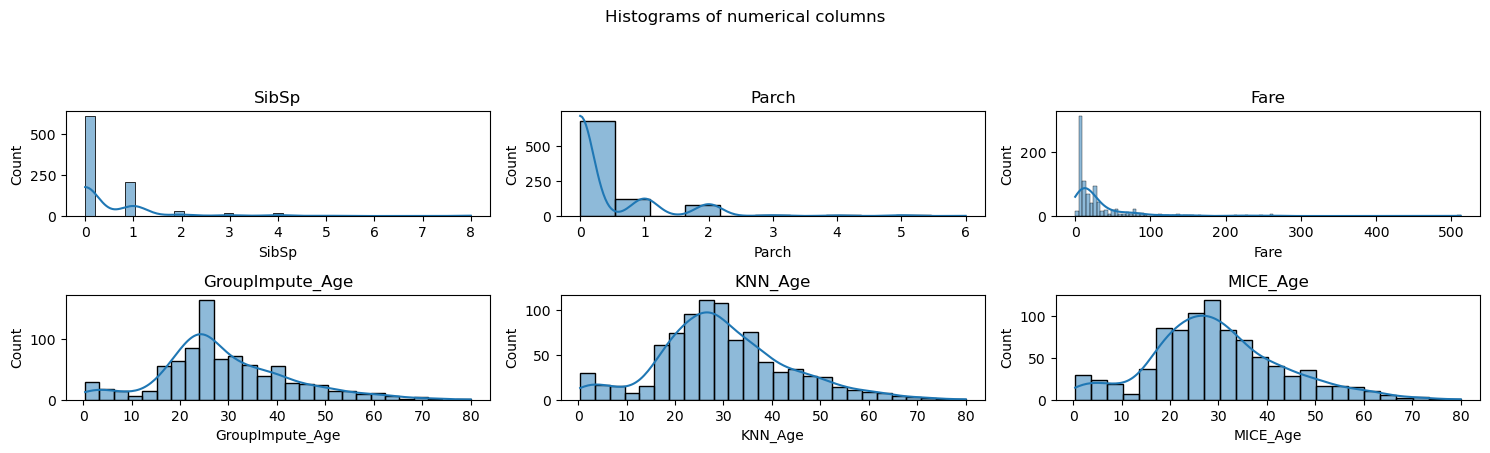

In [48]:
features = ['SibSp', 'Parch', 'Fare', 'GroupImpute_Age', 'KNN_Age', 'MICE_Age']

dataset2 = train_dataset[features]

# Plot histogram
fig = plt.figure(figsize=(15, 12))
plt.suptitle("Histograms of numerical columns")

for i in range(dataset2.shape[1]):
    plt.subplot(6, 3, i+1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])
    
    #vals = np.size(dataset2.iloc[:, i].unique())
    
    #plt.hist(dataset2.iloc[:, i])
    sns.histplot(dataset2.iloc[:, i], kde=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
plt.show()

#### __Observations:__

- We see that there are most passengers have no siblings or spouses aboard the Titanic. About 1/3 does have 1 sibling or spouse on Titanic.
- Similarly, majority of passengers do not have parents on baord Titanic.
- The price of Fares are centred around the lower end, which suggest that most of the passengers are in cheaper bunks with only a few luxurious offerings.
- For all imputed age options, we see that all curves follow a trend where majority of the passengers belong to the age group of 20 to 40 years old.

<Axes: ylabel='Density'>

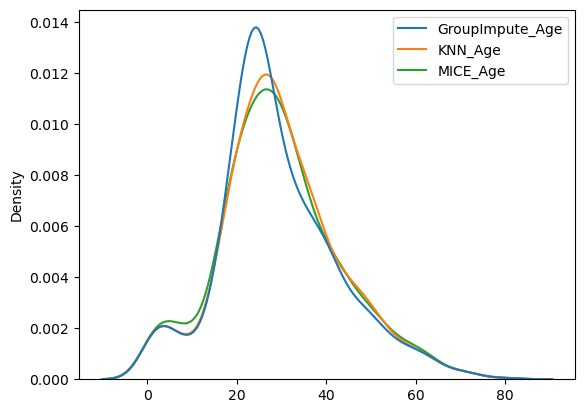

In [49]:
# Overlay all the imputed age
dataset_age = train_dataset[['GroupImpute_Age', 'KNN_Age', 'MICE_Age']]
sns.kdeplot(data=dataset_age)

__Observations:__

The 3 age are closely related with GroupImpute_Age having the highest variance amongst the three for the range of 20 to 30.

<Axes: xlabel='GroupImpute_Age', ylabel='Fare'>

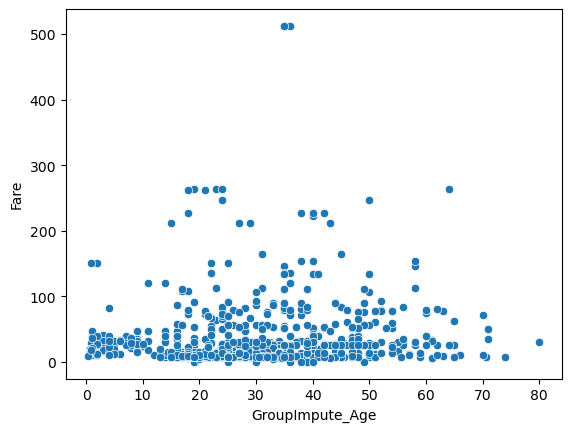

In [50]:
sns.scatterplot(data=dataset2, x="GroupImpute_Age", y="Fare")

__Observations:__

Hypothesise that Age is correlated with Fare, but from the scatter plot, we can see that there is no correlation as majority of the lower Fare prices covers all age ranges.

#### Plot categorical plots

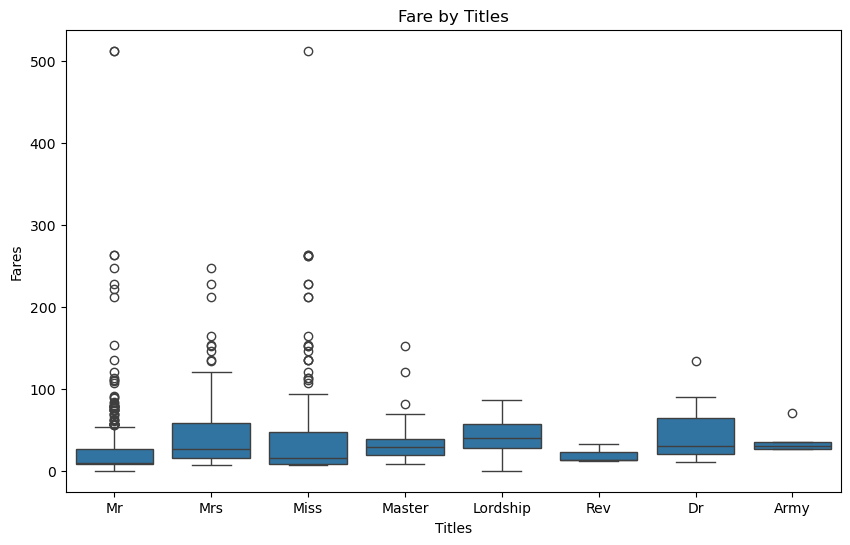

In [51]:
# Observe distribution of fare price by Titles
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=train_dataset, x="Title", y="Fare")

plt.title("Fare by Titles")
plt.xlabel("Titles")
plt.ylabel("Fares")

plt.show()

#### Remove outliers by IQR

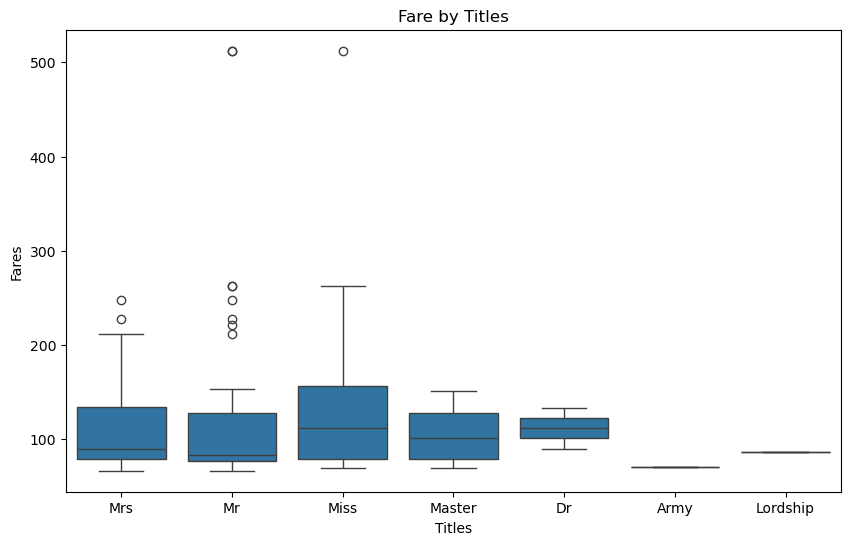

In [52]:
# Since there are so many outliers that the graph looks flat
# Let us remove the outliers and observe
Q1 = train_dataset['Fare'].quantile(0.25)
Q3 = train_dataset['Fare'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
no_outlier_train_dataset = train_dataset[(train_dataset['Fare'] < Q1 - threshold * IQR) | (train_dataset['Fare'] > Q3 + threshold * IQR)]

# Plot the boxplot again
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=no_outlier_train_dataset, x="Title", y="Fare")

plt.title("Fare by Titles")
plt.xlabel("Titles")
plt.ylabel("Fares")

plt.show()

#### Remove outliers by Z score

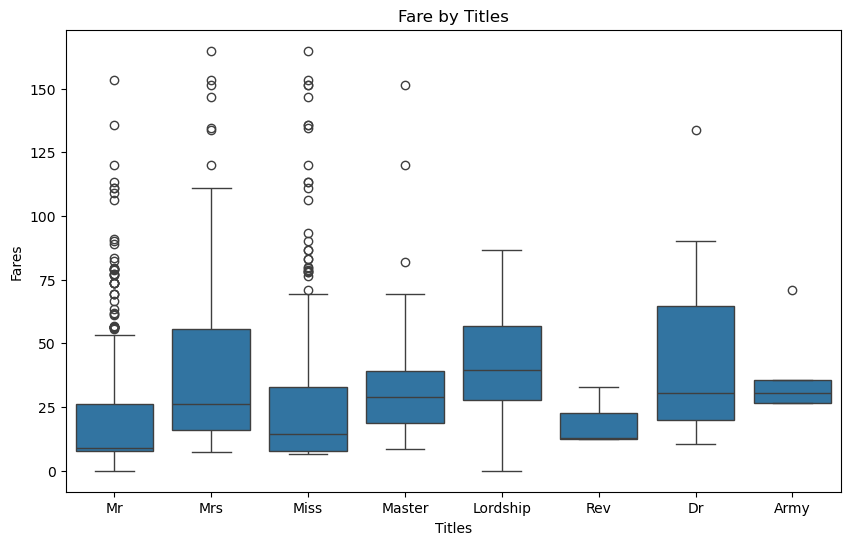

In [53]:
# We can also remove outliers by using Z-score
# Calculate the z-score for each passenger fare
from scipy import stats 
z = np.abs(stats.zscore(train_dataset['Fare']))

# Identify outliers as students with a z-score greater than 3
threshold = 3
no_outlier_train_dataset = train_dataset[z < threshold]

# Plot the boxplot again
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=no_outlier_train_dataset, x="Title", y="Fare")

plt.title("Fare by Titles")
plt.xlabel("Titles")
plt.ylabel("Fares")

plt.show()

__Observations__: 

- We can see that the spread of fares across Mrs, Mr and Miss is the greatest.
- Almost all titles have a median of 25 fare except for Rev and Mr passengers.
- The most outliers (even after removal) is still from Mr and Miss which suggest a wide class of passengers. 

#### Distribution of Customers by Class

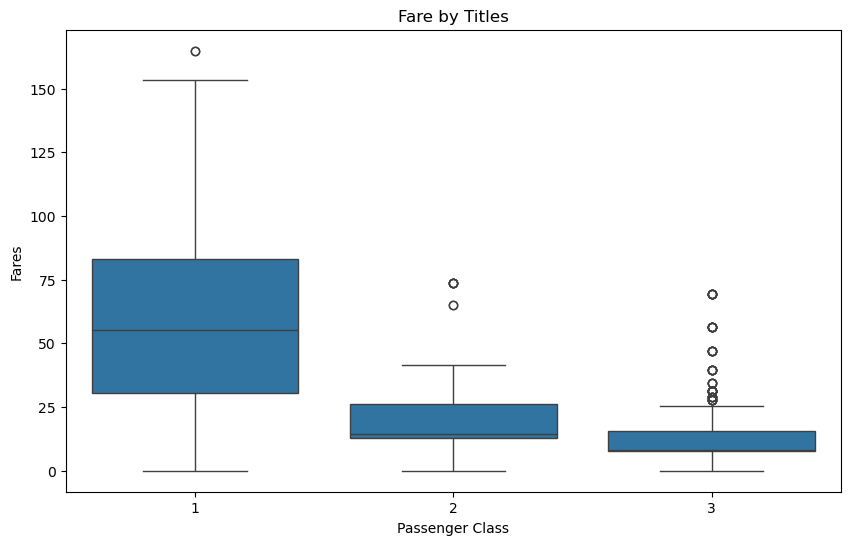

In [54]:
# Observe distribution of fare price by Passenger Class
fig = plt.figure(figsize=(10,6))

# Plot using the data without outlier since we know the graphs will be too compressed otherwise
sns.boxplot(data=no_outlier_train_dataset, x="Pclass", y="Fare")

plt.title("Fare by Titles")
plt.xlabel("Passenger Class")
plt.ylabel("Fares")

plt.show()

__Observations:__

We can see the clear banding of fares between Passenger class 1, 2 and 3 where the most expensive class is Pclass = 1.

#### PClass against Title

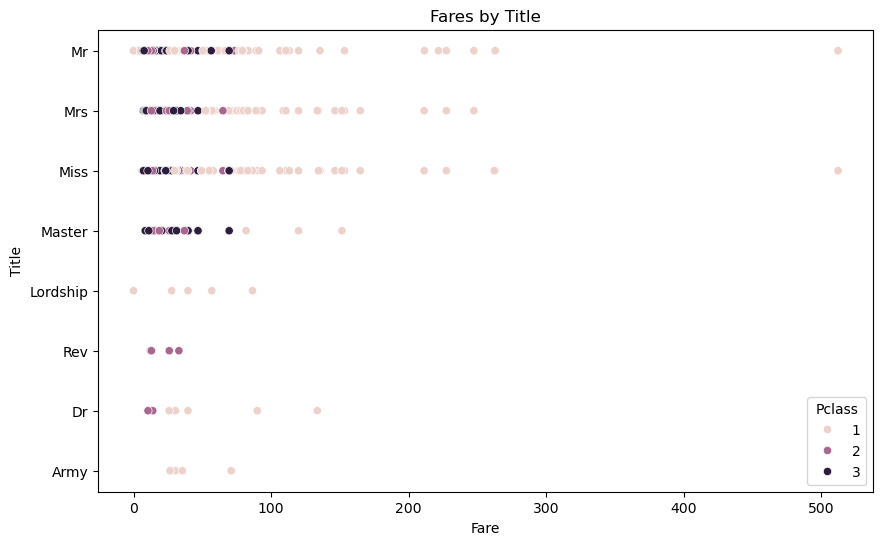

In [55]:
# Observe distribution of Passenger class against Title
fig = plt.figure(figsize=(10,6))
sns.scatterplot(data=train_dataset, y="Title", x="Fare", hue="Pclass")

plt.title("Fares by Title")
plt.xlabel("Fare")
plt.ylabel("Title")

plt.show()

__Observations__: 

We see that the Lordship, Reverends, Doctors and Army passengers only consist of Upper and Middle class despite paying the lower range of fees. Conversely, for the Mr, Mrs, Miss and Master, those in Upper Class paid a wide range of fees.

### Distribution of Gender

C:\Users\Ning\AppData\Local\Temp\ipykernel_21972\9255555.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Female', 'Male'])


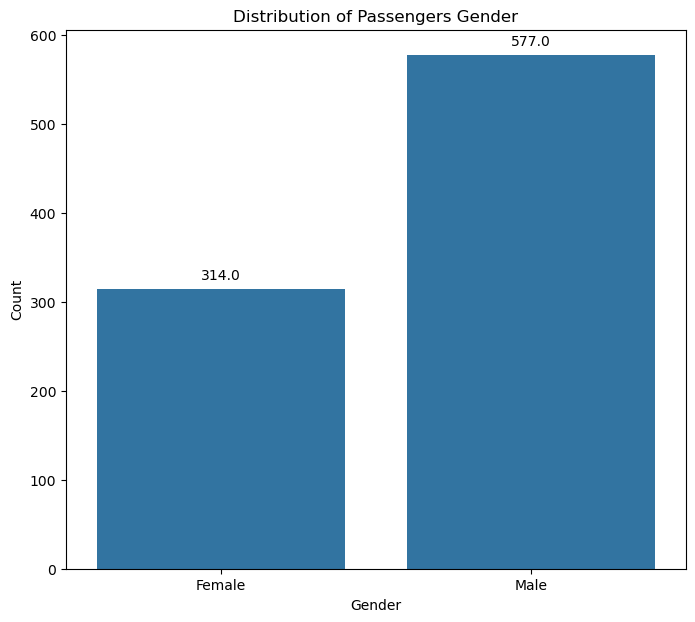

In [56]:
gender_agg = train_dataset[["Sex", "Ticket"]].groupby("Sex").count().reset_index(drop=False)

fig, ax = plt.subplots(figsize=(8, 7))

sns.barplot(data=gender_agg, x="Sex", y="Ticket", ax=ax)

ax.set_title("Distribution of Passengers Gender")
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_xticklabels(['Female', 'Male'])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{}".format(y_value)
        
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points", 
                    ha='center',va=va)

add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False)

### Analyze the survival rate

#### Overall Survival rate

C:\Users\Ning\AppData\Local\Temp\ipykernel_21972\665318924.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Did Not Survive', 'Survived'])


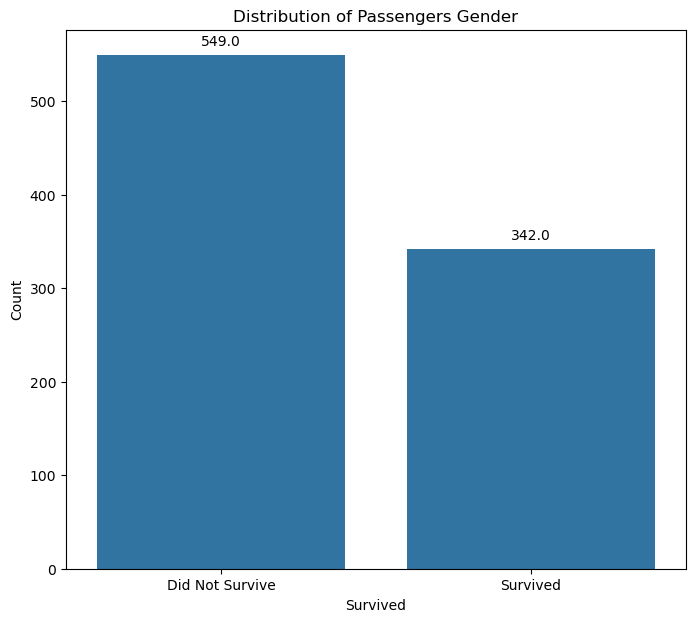

In [57]:
survive_agg = train_dataset[["Survived", "Ticket"]].groupby("Survived").count().reset_index(drop=False)

fig, ax = plt.subplots(figsize=(8, 7))

sns.barplot(data=survive_agg, x="Survived", y="Ticket", ax=ax)

ax.set_title("Distribution of Passengers Gender")
ax.set_xlabel("Survived")
ax.set_ylabel("Count")
ax.set_xticklabels(['Did Not Survive', 'Survived'])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{}".format(y_value)
        
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points", 
                    ha='center',va=va)

add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False)

__Observations:__
    
We see that this is an imbalanced classification problem. There are more non survivals than there are survivals.

#### Survival Rate by Passenger Class

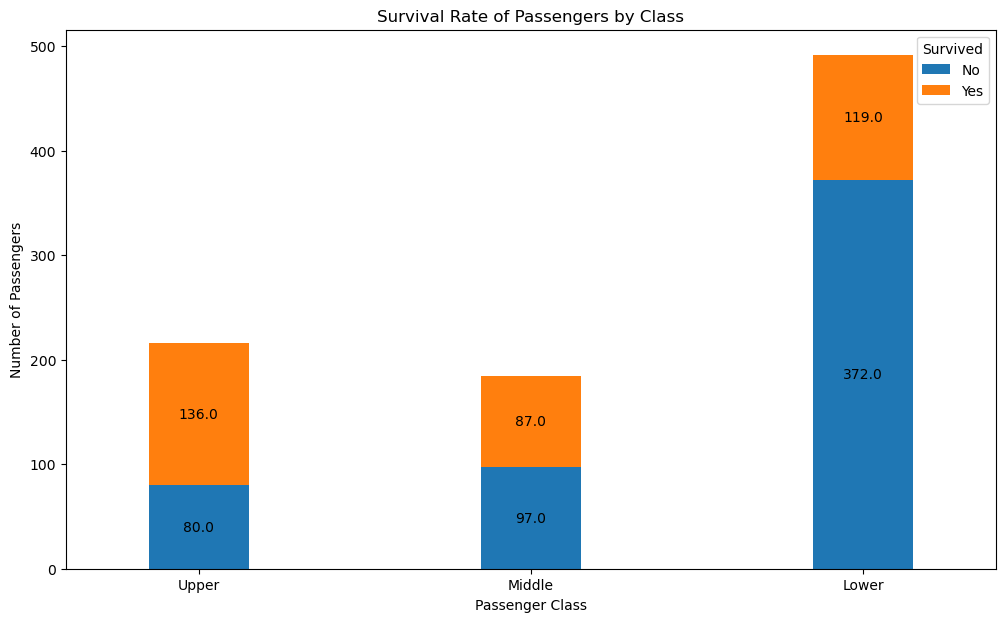

In [58]:
class_survive_df = train_dataset.groupby(['Pclass', 'Survived']).size().unstack()
class_survive_df.rename(columns={0:'No', 1:'Yes'}, inplace=True)

fig, ax = plt.subplots(figsize=(12, 7))
class_survive_df.plot(kind='bar',width = 0.3,stacked = True,rot = 0, ax=ax)

ax.set_title("Survival Rate of Passengers by Class")
ax.set_ylabel("Number of Passengers")
ax.set_xlabel("Passenger Class")
ax.set_xticklabels(["Upper", "Middle", "Lower"])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

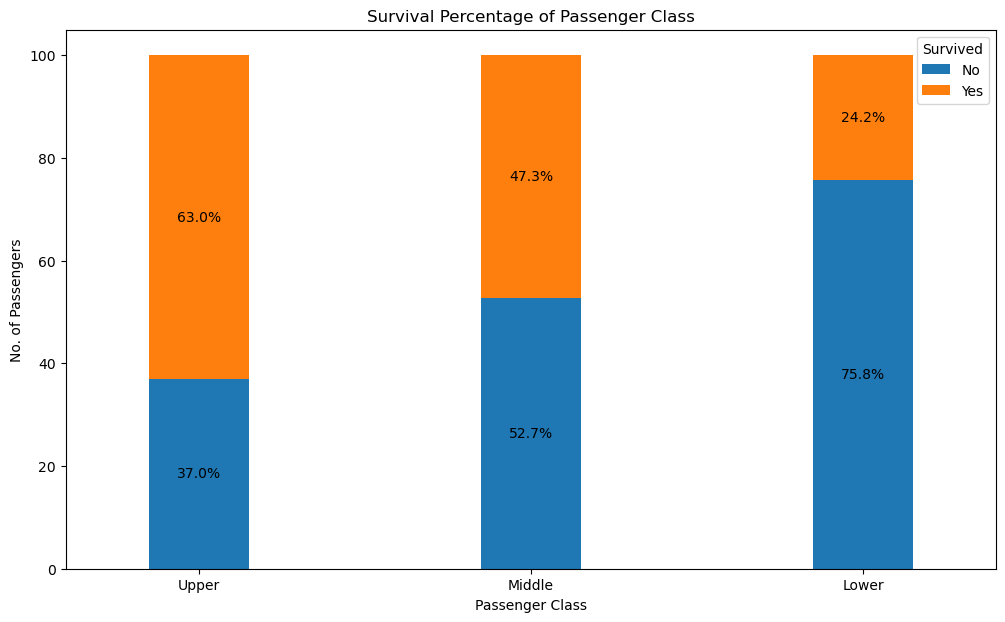

In [59]:
fig, ax = plt.subplots(figsize=(12, 7))
# Change to %
(class_survive_df.T*100/ class_survive_df.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0, ax=ax)

ax.set_title("Survival Percentage of Passenger Class")
ax.set_xlabel("Passenger Class")
ax.set_ylabel("No. of Passengers")
ax.set_xticklabels(["Upper", "Middle", "Lower"])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

__Observations:__

Most of the Lower class customers perished. As the Class reduces, the more casualties there are.

#### Survival Rate by Age

C:\Users\Ning\AppData\Local\Temp\ipykernel_21972\1143796813.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survive_df = train_dataset.groupby(['GroupAgeBins', 'Survived']).size().unstack()


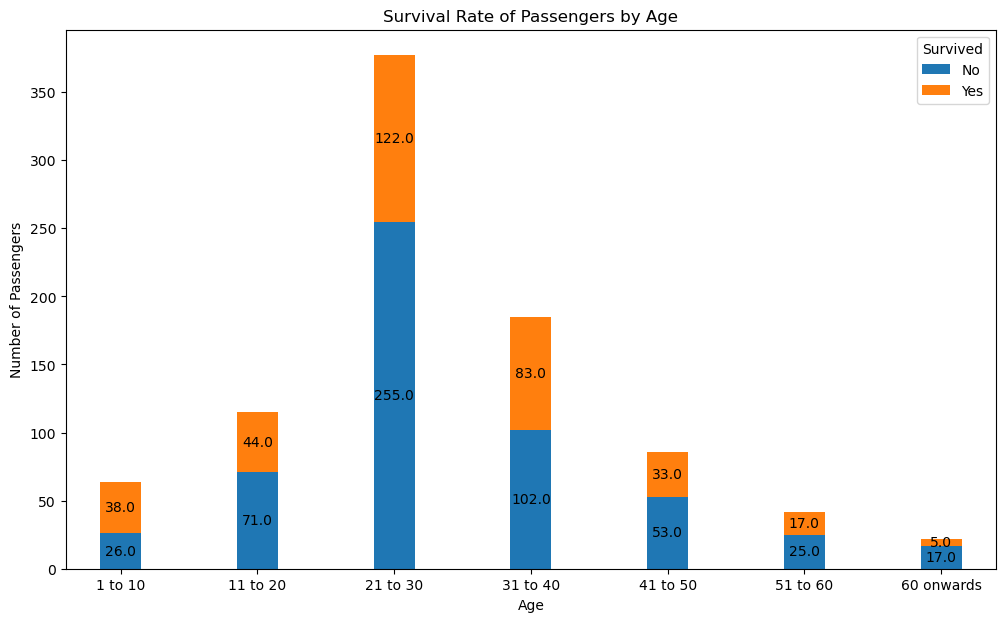

In [60]:
age_range = np.array([0, 10, 20, 30, 40, 50, 60, 100])
train_dataset['GroupAgeBins'] = pd.cut(x=train_dataset['GroupImpute_Age'], bins=age_range,
                    labels=['1 to 10','11 to 20', '21 to 30', '31 to 40',
                            '41 to 50', '51 to 60', '60 onwards'])

age_survive_df = train_dataset.groupby(['GroupAgeBins', 'Survived']).size().unstack()
age_survive_df.rename(columns={0:'No', 1:'Yes'}, inplace=True)

fig, ax = plt.subplots(figsize=(12, 7))
age_survive_df.plot(kind='bar',width = 0.3,stacked = True,rot = 0, ax=ax)

ax.set_title("Survival Rate of Passengers by Age")
ax.set_ylabel("Number of Passengers")
ax.set_xlabel("Age")

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

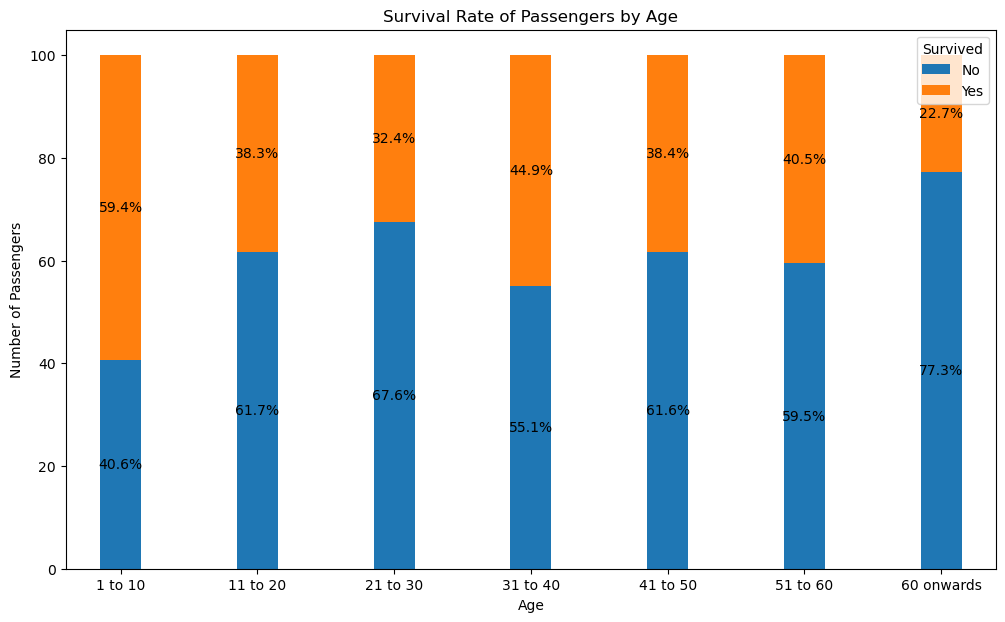

In [61]:
fig, ax = plt.subplots(figsize=(12, 7))
# Change to %
(age_survive_df.T*100/ age_survive_df.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0, ax=ax)

ax.set_title("Survival Rate of Passengers by Age")
ax.set_ylabel("Number of Passengers")
ax.set_xlabel("Age")

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

__Observations:__
    
Survival rate across all passengers did not differ too much at around 40%. The exception is for children aged between 1 to 10. This suggest that priority was given to children on evacuating the ship.

#### Survival Rate by Gender

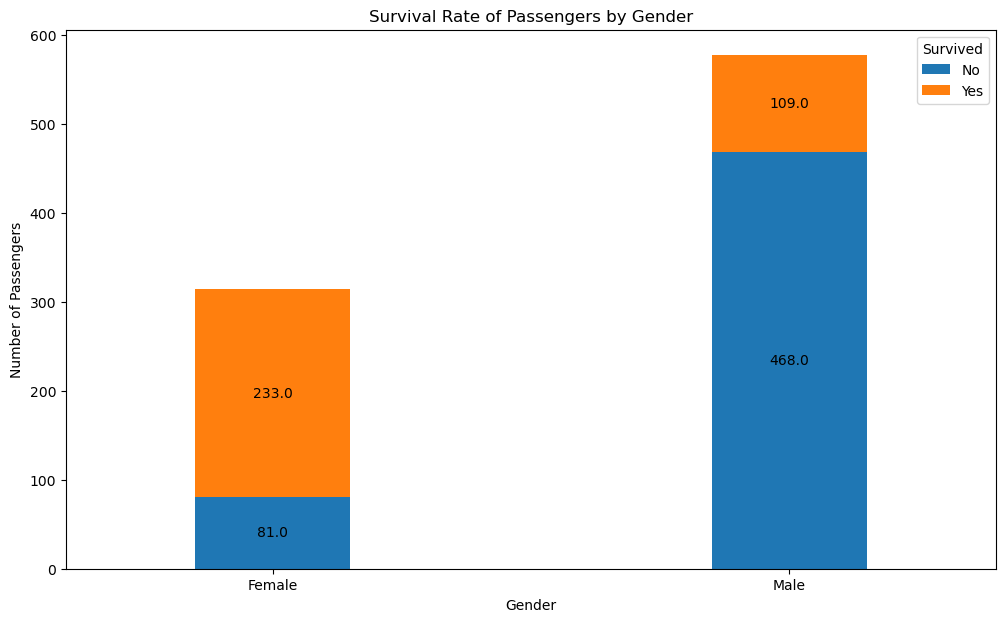

In [62]:
gender_survive_df = train_dataset.groupby(['Sex', 'Survived']).size().unstack()
gender_survive_df.rename(columns={0:'No', 1:'Yes'}, inplace=True)

fig, ax = plt.subplots(figsize=(12, 7))
gender_survive_df.plot(kind='bar',width = 0.3,stacked = True,rot = 0, ax=ax)

ax.set_title("Survival Rate of Passengers by Gender")
ax.set_ylabel("Number of Passengers")
ax.set_xlabel("Gender")
ax.set_xticklabels(["Female", "Male"])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

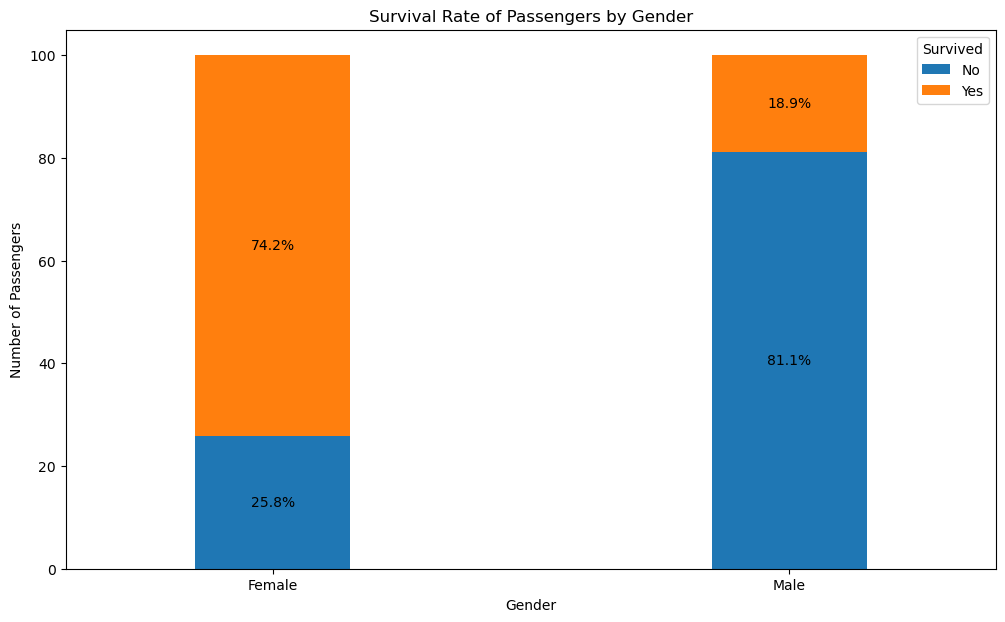

In [63]:
fig, ax = plt.subplots(figsize=(12, 7))
# Change to %
(gender_survive_df.T*100/ gender_survive_df.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0, ax=ax)

ax.set_title("Survival Rate of Passengers by Gender")
ax.set_ylabel("Number of Passengers")
ax.set_xlabel("Gender")
ax.set_xticklabels(["Female", "Male"])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

__Observations:__

We also see that 74% of females survive as opposed to 19% of males. Therefore, there is strong evidence suggesting that woman were also prioritised in evacuation.

### Find Positive and Negative Correlations

In [64]:
dataset2 = train_dataset[['GroupImpute_Age', 'KNN_Age', 'MICE_Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Pclass']]

correlations = dataset2.corrwith(train_dataset.Survived)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations > 0].sort_values(ascending=False)
negative_correlations = correlations[correlations < 0].sort_values(ascending=False)

print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)

Most Positive Correlations: 
 Fare     0.257307
Parch    0.081629
dtype: float64

Most Negative Correlations: 
 SibSp             -0.035322
GroupImpute_Age   -0.059579
MICE_Age          -0.068457
KNN_Age           -0.071382
Pclass            -0.338481
Sex               -0.543351
dtype: float64


#### Plot positive and negative correlations

Text(0, 0.5, 'Correlation value')

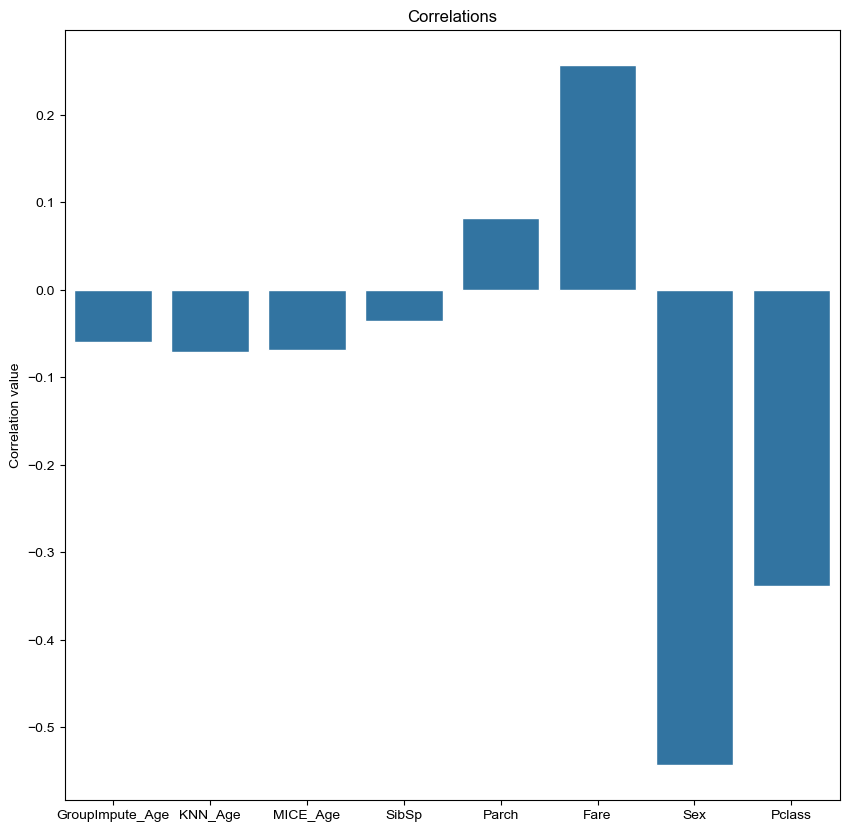

In [65]:
fig, ax = plt.subplots(figsize=(10,10))

sns.set_theme(style="whitegrid")
sns.barplot(data=correlations)

ax.set_title("Correlations")
ax.set_ylabel("Correlation value")

__Observastions:__

We see that Gender and Passenger class are the most negative correlated to Survival, while Fare is the most positively correlated.

<Axes: >

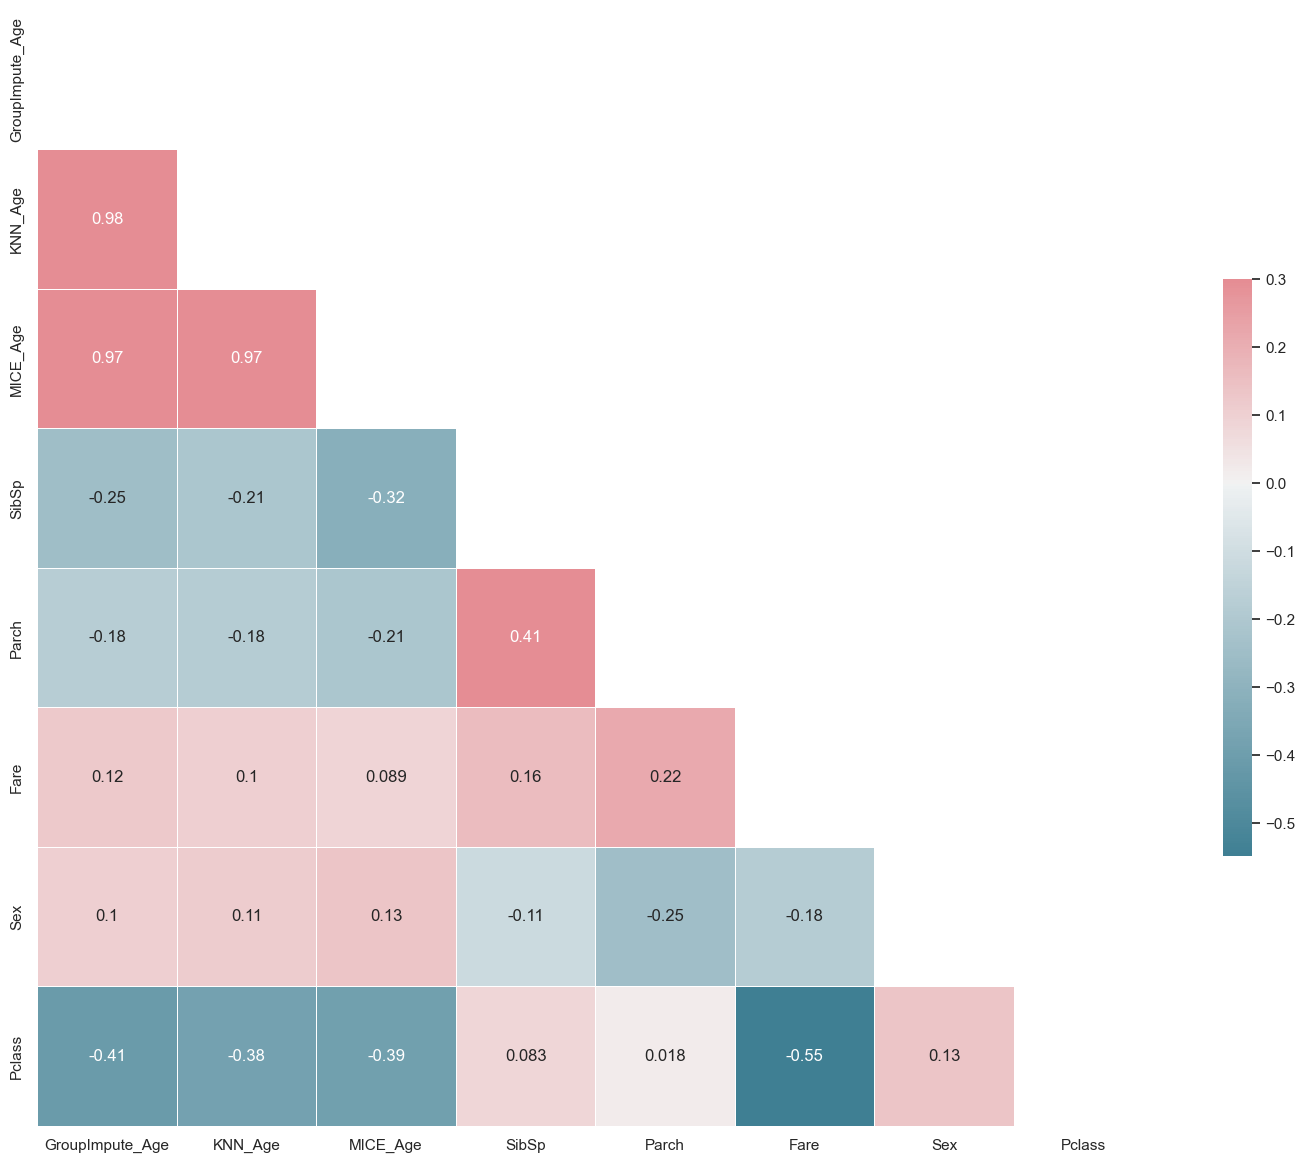

In [66]:
sns.set_theme(style="white")
corr = dataset2.corr()

#Generate a mask for the upper triangle:

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

__Observations:__

We see that the Age and Fare is negatively correlated with Passenger Class. SibSp and Parch is positively correlated as well.

### Conclusion of EDA

- There were missing Age, Embarked, and Fare values. Embarked and Fare were respectively imputed  with most common value, and mean value. Due to the large volume of data missing Age data, three methods of imputation (Grouping, K-Nearest Neighbor and MICE) were used. These will be tested with the models to find the best accuracy.
- Strongest Negative correlations were Sex and Passenger Class. Positive correlations were Parch and Fare
- The dataset is imbalanced with less survivors than non-survivros.
- Most of the survivors are children and women.
- Most of the Upper class passengers were people with standing or titles.
- Most of the passengers were young, from 20 to 30.
- Most of the fare were between 0 to 100.

### Encode categorical data

Using One-hot encoding for the remaining data. Since PClass is already in 1st, 2nd, 3rd class as ordinal encoding, the only remaining categorical is the new feature "Title".

In [67]:
identity = train_dataset['PassengerId']
train_dataset_clean = train_dataset.drop(columns=['PassengerId', 'Age', 'GroupAgeBins', 'Cabin', 'Ticket', 'Name'])

# Convert rest of categorical variable into dummy
train_dataset_clean = pd.get_dummies(train_dataset_clean)

#Rejoin passenger ID to dataset:
train_dataset_clean = pd.concat([train_dataset_clean, identity], axis=1)

In [68]:
train_dataset_clean.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,GroupImpute_Age,KNN_Age,MICE_Age,Cabin_Missing,...,Embarked_S,Title_Army,Title_Dr,Title_Lordship,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,PassengerId
0,0,3,1,1,0,7.2500,22.0,22.0,22.0,1,...,True,False,False,False,False,False,True,False,False,1
1,1,1,0,1,0,71.2833,38.0,38.0,38.0,0,...,False,False,False,False,False,False,False,True,False,2
2,1,3,0,0,0,7.9250,26.0,26.0,26.0,1,...,True,False,False,False,False,True,False,False,False,3
3,1,1,0,1,0,53.1000,35.0,35.0,35.0,0,...,True,False,False,False,False,False,False,True,False,4
4,0,3,1,0,0,8.0500,35.0,35.0,35.0,1,...,True,False,False,False,False,False,True,False,False,5


In [205]:
# Do the same for test dataset
identity_test = test_dataset['PassengerId']
test_dataset_clean = test_dataset.drop(columns=['PassengerId', 'Age', 'Cabin', 'Ticket', 'Name'])

# Convert rest of categorical variable into dummy
test_dataset_clean = pd.get_dummies(test_dataset_clean)

#Rejoin passenger ID to dataset:
test_dataset_clean = pd.concat([test_dataset_clean, identity_test], axis=1)

## Train Test Split

In order to train the model properly, we need to include a fair representation of training and testing data. We will train the data on one set of data, before testing it on the other data.

For each model we train on, we will investigate the accuracy, precision, f1, f2 scores and pick the best model amongst. Furthermore, we will aim to figure out which imputation method is the best for the column `Age`.

In [69]:
# Declare target variable
y = train_dataset_clean['Survived']
X = train_dataset_clean.drop(columns=['Survived'])

In [70]:
# Split into test and train set with test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (712, 21)
Number transactions y_train dataset:  (712,)
Number transactions X_test dataset:  (179, 21)
Number transactions y_test dataset:  (179,)


In [71]:
# Remove identifiers
train_identity = X_train['PassengerId']
X_train = X_train.drop(columns=['PassengerId'])

test_identity = X_test['PassengerId']
X_test = X_test.drop(columns=['PassengerId'])

In [72]:
# Conduct Feature Scaling
sc = StandardScaler()

X_train2 = pd.DataFrame(sc.fit_transform(X_train))
X_train2.columns = X_train.columns
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc.transform(X_test))
X_test2.columns = X_test.columns
X_test2.index = X_test.index.values
X_test = X_test2

## Model Selection

In this section, we will test the following models:

- Logistic Regression
- Support Vector Model (Linear)
- Support Vector Model (RBF)
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Tree
- Naive Bayesian
- K-Nearest Neighbor

We will do this 3 times with each set of Age. Remember that we have imputed
- Group Imputing (Grouping by Class and Sex)
- K-Nearest Neighbor (Scikit Learn KNN Imputer)
- Multivariate Imputation by Chained Equations

In [74]:
groupAge_features = X_train.columns.to_list()
groupAge_features.remove('KNN_Age')
groupAge_features.remove('MICE_Age')
X_train_grp = X_train[groupAge_features]
X_test_grp = X_test[groupAge_features]

knn_features = X_train.columns.to_list()
knn_features.remove('GroupImpute_Age')
knn_features.remove('MICE_Age')
X_train_knn = X_train[knn_features]
X_test_knn = X_test[knn_features]

mice_features = X_train.columns.to_list()
mice_features.remove('GroupImpute_Age')
mice_features.remove('KNN_Age')
X_train_mice = X_train[mice_features]
X_test_mice = X_test[mice_features]

In [75]:
# Declare Kfold
kfold = KFold(n_splits=10, shuffle=True)

### Logistic Regression

In [76]:
# Declare a LR model only comparison
lr_models = {}

In [77]:
# Declare logistic regression model
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train_grp, y_train)

lr_acc_results_grp = cross_val_score(lr, X_train_grp, y_train, cv=kfold, scoring='accuracy')
lr_auc_results_grp = cross_val_score(lr, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", lr_acc_results_grp)
print("Mean cross-validation accuracy score:", lr_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", lr_auc_results_grp)
print("Mean cross-validation ROC AUC score:", lr_auc_results_grp.mean())

Cross-validation accuracy scores: [0.80555556 0.875      0.83098592 0.81690141 0.81690141 0.84507042
 0.77464789 0.8028169  0.90140845 0.81690141]
Mean cross-validation accuracy score: 0.8286189358372458
Cross-validation ROC AUC scores: [0.71984127 0.89529221 0.93939394 0.83471761 0.82016129 0.9384058
 0.77804878 0.83428571 0.94559801 0.91465677]
Mean cross-validation ROC AUC score: 0.8620401385642535


In [78]:
# Declare logistic regression model
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train_knn, y_train)

lr_acc_results_knn = cross_val_score(lr, X_train_knn, y_train, cv=kfold, scoring='accuracy')
lr_auc_results_knn = cross_val_score(lr, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", lr_acc_results_knn)
print("Mean cross-validation accuracy score:", lr_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", lr_auc_results_knn)
print("Mean cross-validation ROC AUC score:", lr_auc_results_knn.mean())

Cross-validation accuracy scores: [0.81944444 0.81944444 0.8028169  0.78873239 0.88732394 0.78873239
 0.92957746 0.74647887 0.8028169  0.88732394]
Mean cross-validation accuracy score: 0.8272691705790297
Cross-validation ROC AUC scores: [0.86024306 0.90401259 0.75042735 0.8525641  0.825      0.82652174
 0.89825119 0.91904762 0.86923077 0.85815603]
Mean cross-validation ROC AUC score: 0.8563454445206448


In [79]:
# Declare logistic regression model
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train_mice, y_train)

lr_acc_results_mice = cross_val_score(lr, X_train_mice, y_train, cv=kfold, scoring='accuracy')
lr_auc_results_mice = cross_val_score(lr, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", lr_acc_results_mice)
print("Mean cross-validation accuracy score:", lr_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", lr_auc_results_mice)
print("Mean cross-validation ROC AUC score:", lr_auc_results_mice.mean())

Cross-validation accuracy scores: [0.79166667 0.81944444 0.77464789 0.94366197 0.73239437 0.84507042
 0.78873239 0.87323944 0.85915493 0.83098592]
Mean cross-validation accuracy score: 0.8258998435054773
Cross-validation ROC AUC scores: [0.81740482 0.84895833 0.95155993 0.85641026 0.91586538 0.86952862
 0.86868687 0.73052536 0.93877551 0.79565217]
Mean cross-validation ROC AUC score: 0.85933672607338


In [80]:
# Evaluating across Logistic Regression for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

lr_models['GroupingImpute'] = [lr_auc_results_grp.mean(), lr_auc_results_grp.std(), lr_acc_results_grp.mean(), lr_acc_results_grp.std()]
lr_models['K-Nearest'] = [lr_auc_results_knn.mean(), lr_auc_results_knn.std(), lr_acc_results_knn.mean(), lr_acc_results_knn.std()]
lr_models['MICE'] = [lr_auc_results_mice.mean(), lr_auc_results_mice.std(), lr_acc_results_mice.mean(), lr_acc_results_mice.std()]

results_lr = pd.DataFrame.from_dict(lr_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))

print(f"The highest ROC AUC Mean is {results_lr['ROC AUC Mean'].idxmax()} at {max(results_lr['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_lr['Accuracy Mean'].idxmax()} at {max(results_lr['Accuracy Mean'].values)}")
results_lr

The highest ROC AUC Mean is GroupingImpute at 0.8620401385642535
The highest Accuracy Mean is GroupingImpute at 0.8286189358372458


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.862040,0.072950,0.828619,0.034997
K-Nearest,0.856345,0.046097,0.827269,0.053381
MICE,0.859337,0.063816,0.825900,0.056190


### Support Vector Machine (Linear)

In [81]:
# Declare variable to store models
svml_models = {}

In [82]:
# Declare Support Vector model
svml = SVC(kernel='linear', random_state=0)
svml.fit(X_train_grp, y_train)

svml_acc_results_grp = cross_val_score(svml, X_train_grp, y_train, cv=kfold, scoring='accuracy')
svml_auc_results_grp = cross_val_score(svml, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", svml_acc_results_grp)
print("Mean cross-validation accuracy score:", svml_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", svml_auc_results_grp)
print("Mean cross-validation ROC AUC score:", svml_auc_results_grp.mean())

Cross-validation accuracy scores: [0.83333333 0.81944444 0.8028169  0.84507042 0.71830986 0.77464789
 0.81690141 0.92957746 0.84507042 0.84507042]
Mean cross-validation accuracy score: 0.8230242566510173
Cross-validation ROC AUC scores: [0.76296296 0.84375    0.81565217 0.94186047 0.82881773 0.80980392
 0.84552846 0.86619048 0.84358974 0.86097561]
Mean cross-validation ROC AUC score: 0.841913154237193


In [83]:
# Declare Support Vector model
svml = SVC(kernel='linear', random_state=0)
svml.fit(X_train_knn, y_train)

svml_acc_results_knn = cross_val_score(svml, X_train_knn, y_train, cv=kfold, scoring='accuracy')
svml_auc_results_knn = cross_val_score(svml, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", svml_acc_results_knn)
print("Mean cross-validation accuracy score:", svml_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", svml_auc_results_knn)
print("Mean cross-validation ROC AUC score:", svml_auc_results_knn.mean())

Cross-validation accuracy scores: [0.80555556 0.86111111 0.73239437 0.77464789 0.87323944 0.83098592
 0.74647887 0.90140845 0.83098592 0.83098592]
Mean cross-validation accuracy score: 0.8187793427230048
Cross-validation ROC AUC scores: [0.83319398 0.89378442 0.91528239 0.75415282 0.86699507 0.83414634
 0.78239203 0.82857143 0.88047138 0.85196078]
Mean cross-validation ROC AUC score: 0.8440950652884787


In [84]:
# Declare Support Vector model
svml = SVC(kernel='linear', random_state=0)
svml.fit(X_train_mice, y_train)

svml_acc_results_mice = cross_val_score(svml, X_train_mice, y_train, cv=kfold, scoring='accuracy')
svml_auc_results_mice = cross_val_score(svml, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", svml_acc_results_mice)
print("Mean cross-validation accuracy score:", svml_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", svml_auc_results_mice)
print("Mean cross-validation ROC AUC score:", svml_auc_results_mice.mean())

Cross-validation accuracy scores: [0.83333333 0.81944444 0.81690141 0.73239437 0.90140845 0.88732394
 0.78873239 0.88732394 0.77464789 0.84507042]
Mean cross-validation accuracy score: 0.8286580594679187
Cross-validation ROC AUC scores: [0.83246528 0.86363636 0.77177419 0.88043478 0.85428571 0.83869565
 0.8736089  0.78619529 0.91932624 0.81527094]
Mean cross-validation ROC AUC score: 0.8435693350342148


In [85]:
# Evaluating across SVM for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

svml_models['GroupingImpute'] = [svml_auc_results_grp.mean(), svml_auc_results_grp.std(), svml_acc_results_grp.mean(), svml_acc_results_grp.std()]
svml_models['K-Nearest'] = [svml_auc_results_knn.mean(), svml_auc_results_knn.std(), svml_acc_results_knn.mean(), svml_acc_results_knn.std()]
svml_models['MICE'] = [svml_auc_results_mice.mean(), svml_auc_results_mice.std(), svml_acc_results_mice.mean(), svml_acc_results_mice.std()]

results_svml = pd.DataFrame.from_dict(svml_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_svml['ROC AUC Mean'].idxmax()} at {max(results_svml['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_svml['Accuracy Mean'].idxmax()} at {max(results_svml['Accuracy Mean'].values)}")

results_svml

The highest ROC AUC Mean is K-Nearest at 0.8440950652884787
The highest Accuracy Mean is MICE at 0.8286580594679187


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.841913,0.043688,0.823024,0.051655
K-Nearest,0.844095,0.046692,0.818779,0.051812
MICE,0.843569,0.042323,0.828658,0.051447


### Support Vector Machine (RBF)

In [86]:
# Declare variable to store models
svmk_models = {}

In [87]:
# Declare Support Vector model
svmk = SVC(kernel='rbf', random_state=0)
svmk.fit(X_train_grp, y_train)

svmk_acc_results_grp = cross_val_score(svmk, X_train_grp, y_train, cv=kfold, scoring='accuracy')
svmk_auc_results_grp = cross_val_score(svmk, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", svmk_acc_results_grp)
print("Mean cross-validation accuracy score:", svmk_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", svmk_auc_results_grp)
print("Mean cross-validation ROC AUC score:", svmk_auc_results_grp.mean())

Cross-validation accuracy scores: [0.79166667 0.81944444 0.81690141 0.8028169  0.94366197 0.85915493
 0.87323944 0.77464789 0.77464789 0.90140845]
Mean cross-validation accuracy score: 0.8357589984350549
Cross-validation ROC AUC scores: [0.82021104 0.88287489 0.8763587  0.87624585 0.75854701 0.80982906
 0.88211382 0.84574468 0.83658537 0.81219512]
Mean cross-validation ROC AUC score: 0.8400705529045582


In [88]:
# Declare Support Vector model
svmk = SVC(kernel='rbf', random_state=0)
svmk.fit(X_train_knn, y_train)

svmk_acc_results_knn = cross_val_score(svmk, X_train_knn, y_train, cv=kfold, scoring='accuracy')
svmk_auc_results_knn = cross_val_score(svmk, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", svmk_acc_results_knn)
print("Mean cross-validation accuracy score:", svmk_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", svmk_auc_results_knn)
print("Mean cross-validation ROC AUC score:", svmk_auc_results_knn.mean())

Cross-validation accuracy scores: [0.81944444 0.80555556 0.84507042 0.87323944 0.87323944 0.83098592
 0.77464789 0.83098592 0.81690141 0.88732394]
Mean cross-validation accuracy score: 0.8357394366197182
Cross-validation ROC AUC scores: [0.92288961 0.81973582 0.84148551 0.84260731 0.87137681 0.77016129
 0.7987013  0.6745098  0.9326087  0.87356322]
Mean cross-validation ROC AUC score: 0.8347639369149984


In [89]:
# Declare Support Vector model
svmk = SVC(kernel='rbf', random_state=0)
svmk.fit(X_train_mice, y_train)

svmk_acc_results_mice = cross_val_score(svmk, X_train_mice, y_train, cv=kfold, scoring='accuracy')
svmk_auc_results_mice = cross_val_score(svmk, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", svmk_acc_results_mice)
print("Mean cross-validation accuracy score:", svmk_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", svmk_auc_results_mice)
print("Mean cross-validation ROC AUC score:", svmk_auc_results_mice.mean())

Cross-validation accuracy scores: [0.93055556 0.84722222 0.83098592 0.85915493 0.81690141 0.84507042
 0.81690141 0.90140845 0.74647887 0.78873239]
Mean cross-validation accuracy score: 0.8383411580594679
Cross-validation ROC AUC scores: [0.84496753 0.83360064 0.83386328 0.88695652 0.77304348 0.78846154
 0.90483871 0.82095238 0.89105691 0.83589744]
Mean cross-validation ROC AUC score: 0.8413638424604853


In [90]:
# Evaluating across SVM for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

svmk_models['GroupingImpute'] = [svmk_auc_results_grp.mean(), svmk_auc_results_grp.std(), svmk_acc_results_grp.mean(), svmk_acc_results_grp.std()]
svmk_models['K-Nearest'] = [svmk_auc_results_knn.mean(), svmk_auc_results_knn.std(), svmk_acc_results_knn.mean(), svmk_acc_results_knn.std()]
svmk_models['MICE'] = [svmk_auc_results_mice.mean(), svmk_auc_results_mice.std(), svmk_acc_results_mice.mean(), svmk_acc_results_mice.std()]

results_svmk = pd.DataFrame.from_dict(svmk_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_svmk['ROC AUC Mean'].idxmax()} at {max(results_svmk['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_svmk['Accuracy Mean'].idxmax()} at {max(results_svmk['Accuracy Mean'].values)}")

results_svmk

The highest ROC AUC Mean is MICE at 0.8413638424604853
The highest Accuracy Mean is MICE at 0.8383411580594679


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.840071,0.038732,0.835759,0.053875
K-Nearest,0.834764,0.071884,0.835739,0.032969
MICE,0.841364,0.040767,0.838341,0.049911


### Decision Tree

In [91]:
# Declare variable to store models
tree_models = {}

In [92]:
# Declare Decision Tree Classifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
tree.fit(X_train_grp, y_train)

tree_acc_results_grp = cross_val_score(tree, X_train_grp, y_train, cv=kfold, scoring='accuracy')
tree_auc_results_grp = cross_val_score(tree, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", tree_acc_results_grp)
print("Mean cross-validation accuracy score:", tree_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", tree_auc_results_grp)
print("Mean cross-validation ROC AUC score:", tree_auc_results_grp.mean())

Cross-validation accuracy scores: [0.83333333 0.80555556 0.77464789 0.81690141 0.81690141 0.81690141
 0.81690141 0.87323944 0.90140845 0.8028169 ]
Mean cross-validation accuracy score: 0.8258607198748044
Cross-validation ROC AUC scores: [0.82291667 0.86204013 0.77925532 0.87540064 0.90987319 0.91091954
 0.82714286 0.88252033 0.83637874 0.82379032]
Mean cross-validation ROC AUC score: 0.8530237731724473


In [93]:
# Declare Decision Tree Classifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
tree.fit(X_train_knn, y_train)

tree_acc_results_knn = cross_val_score(tree, X_train_knn, y_train, cv=kfold, scoring='accuracy')
tree_auc_results_knn = cross_val_score(tree, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", tree_acc_results_knn)
print("Mean cross-validation accuracy score:", tree_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", tree_auc_results_knn)
print("Mean cross-validation ROC AUC score:", tree_auc_results_knn.mean())

Cross-validation accuracy scores: [0.83333333 0.86111111 0.78873239 0.81690141 0.73239437 0.84507042
 0.81690141 0.76056338 0.88732394 0.8028169 ]
Mean cross-validation accuracy score: 0.8145148669796557
Cross-validation ROC AUC scores: [0.89454691 0.94197531 0.82092199 0.79487179 0.92258065 0.95412458
 0.82735043 0.66489362 0.9326087  0.83740942]
Mean cross-validation ROC AUC score: 0.8591283386519193


In [94]:
# Declare Decision Tree Classifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
tree.fit(X_train_mice, y_train)

tree_acc_results_mice = cross_val_score(tree, X_train_mice, y_train, cv=kfold, scoring='accuracy')
tree_auc_results_mice = cross_val_score(tree, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", tree_acc_results_mice)
print("Mean cross-validation accuracy score:", tree_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", tree_auc_results_mice)
print("Mean cross-validation ROC AUC score:", tree_auc_results_mice.mean())

Cross-validation accuracy scores: [0.875      0.76388889 0.83098592 0.83098592 0.8028169  0.81690141
 0.73239437 0.73239437 0.8028169  0.83098592]
Mean cross-validation accuracy score: 0.8019170579029733
Cross-validation ROC AUC scores: [0.77901235 0.81574675 0.77043478 0.83796296 0.87276423 0.91187384
 0.84975962 0.89434783 0.83866995 0.85960145]
Mean cross-validation ROC AUC score: 0.8430173754070822


In [95]:
# Evaluating across Decision Tree for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

tree_models['GroupingImpute'] = [tree_auc_results_grp.mean(), tree_auc_results_grp.std(), tree_acc_results_grp.mean(), tree_acc_results_grp.std()]
tree_models['K-Nearest'] = [tree_auc_results_knn.mean(), tree_auc_results_knn.std(), tree_acc_results_knn.mean(), tree_acc_results_knn.std()]
tree_models['MICE'] = [tree_auc_results_mice.mean(), tree_auc_results_mice.std(), tree_acc_results_mice.mean(), tree_acc_results_mice.std()]

results_tree = pd.DataFrame.from_dict(tree_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_tree['ROC AUC Mean'].idxmax()} at {max(results_tree['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_tree['Accuracy Mean'].idxmax()} at {max(results_tree['Accuracy Mean'].values)}")

results_tree

The highest ROC AUC Mean is K-Nearest at 0.8591283386519193
The highest Accuracy Mean is GroupingImpute at 0.8258607198748044


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.853024,0.040231,0.825861,0.034489
K-Nearest,0.859128,0.084478,0.814515,0.043849
MICE,0.843017,0.043283,0.801917,0.043835


### Random Forest Classifier

In [96]:
rf_models = {}

In [97]:
# Declare Random Tree Classifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
random_forest.fit(X_train_grp, y_train)

rf_acc_results_grp = cross_val_score(random_forest, X_train_grp, y_train, cv=kfold, scoring='accuracy')
rf_auc_results_grp = cross_val_score(random_forest, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", rf_acc_results_grp)
print("Mean cross-validation accuracy score:", rf_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", rf_auc_results_grp)
print("Mean cross-validation ROC AUC score:", rf_auc_results_grp.mean())

Cross-validation accuracy scores: [0.81944444 0.79166667 0.8028169  0.74647887 0.78873239 0.83098592
 0.81690141 0.87323944 0.76056338 0.76056338]
Mean cross-validation accuracy score: 0.7991392801251956
Cross-validation ROC AUC scores: [0.818107   0.86911197 0.93043478 0.86658249 0.88846154 0.83487941
 0.83858998 0.8255814  0.88704319 0.82606838]
Mean cross-validation ROC AUC score: 0.8584860126190554


In [98]:
# Declare Random Tree Classifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
random_forest.fit(X_train_knn, y_train)

rf_acc_results_knn = cross_val_score(random_forest, X_train_knn, y_train, cv=kfold, scoring='accuracy')
rf_auc_results_knn = cross_val_score(random_forest, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", rf_acc_results_knn)
print("Mean cross-validation accuracy score:", rf_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", rf_auc_results_knn)
print("Mean cross-validation ROC AUC score:", rf_auc_results_knn.mean())

Cross-validation accuracy scores: [0.73611111 0.80555556 0.88732394 0.81690141 0.74647887 0.85915493
 0.90140845 0.8028169  0.74647887 0.84507042]
Mean cross-validation accuracy score: 0.8147300469483568
Cross-validation ROC AUC scores: [0.79829787 0.91070024 0.886289   0.8203252  0.93770764 0.88953488
 0.8826087  0.78039216 0.81608696 0.87584175]
Mean cross-validation ROC AUC score: 0.8597784394780394


In [99]:
# Declare Random Tree Classifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
random_forest.fit(X_train_mice, y_train)

rf_acc_results_mice = cross_val_score(random_forest, X_train_mice, y_train, cv=kfold, scoring='accuracy')
rf_auc_results_mice = cross_val_score(random_forest, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", rf_acc_results_mice)
print("Mean cross-validation accuracy score:", rf_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", rf_auc_results_mice)
print("Mean cross-validation ROC AUC score:", rf_auc_results_mice.mean())

Cross-validation accuracy scores: [0.86111111 0.76388889 0.85915493 0.78873239 0.76056338 0.74647887
 0.84507042 0.8028169  0.85915493 0.78873239]
Mean cross-validation accuracy score: 0.8075704225352114
Cross-validation ROC AUC scores: [0.83854167 0.79591018 0.91320598 0.84313725 0.84855769 0.80597643
 0.81260163 0.89677419 0.75434783 0.9471243 ]
Mean cross-validation ROC AUC score: 0.8456177159280622


In [100]:
# Evaluating across Random Forest for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

rf_models['GroupingImpute'] = [rf_auc_results_grp.mean(), rf_auc_results_grp.std(), rf_acc_results_grp.mean(), rf_acc_results_grp.std()]
rf_models['K-Nearest'] = [rf_auc_results_knn.mean(), rf_auc_results_knn.std(), rf_acc_results_knn.mean(), rf_acc_results_knn.std()]
rf_models['MICE'] = [rf_auc_results_mice.mean(), rf_auc_results_mice.std(), rf_acc_results_mice.mean(), rf_acc_results_mice.std()]

results_rf = pd.DataFrame.from_dict(rf_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_rf['ROC AUC Mean'].idxmax()} at {max(results_rf['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_rf['Accuracy Mean'].idxmax()} at {max(results_rf['Accuracy Mean'].values)}")

results_rf

The highest ROC AUC Mean is K-Nearest at 0.8597784394780394
The highest Accuracy Mean is K-Nearest at 0.8147300469483568


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.858486,0.034331,0.799139,0.036276
K-Nearest,0.859778,0.049579,0.814730,0.056040
MICE,0.845618,0.055692,0.807570,0.042635


### XGBoost Classifier

In [101]:
xgb_models = {}

In [102]:
# Declare XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=0, n_jobs=-1)
xgb.fit(X_train_grp, y_train)

xgb_acc_results_grp = cross_val_score(xgb, X_train_grp, y_train, cv=kfold, scoring='accuracy')
xgb_auc_results_grp = cross_val_score(xgb, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", xgb_acc_results_grp)
print("Mean cross-validation accuracy score:", xgb_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", xgb_auc_results_grp)
print("Mean cross-validation ROC AUC score:", xgb_auc_results_grp.mean())

Cross-validation accuracy scores: [0.84722222 0.80555556 0.76056338 0.83098592 0.77464789 0.87323944
 0.83098592 0.84507042 0.78873239 0.83098592]
Mean cross-validation accuracy score: 0.818798904538341
Cross-validation ROC AUC scores: [0.84114583 0.840625   0.85384615 0.89761905 0.82380952 0.90406977
 0.78333333 0.76837607 0.9203252  0.81282051]
Mean cross-validation ROC AUC score: 0.8445970443831866


In [103]:
# Declare XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=0, n_jobs=-1)
xgb.fit(X_train_knn, y_train)

xgb_acc_results_knn = cross_val_score(xgb, X_train_knn, y_train, cv=kfold, scoring='accuracy')
xgb_auc_results_knn = cross_val_score(xgb, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", xgb_acc_results_knn)
print("Mean cross-validation accuracy score:", xgb_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", xgb_auc_results_knn)
print("Mean cross-validation ROC AUC score:", xgb_auc_results_knn.mean())

Cross-validation accuracy scores: [0.83333333 0.79166667 0.77464789 0.81690141 0.88732394 0.94366197
 0.85915493 0.81690141 0.77464789 0.83098592]
Mean cross-validation accuracy score: 0.8329225352112676
Cross-validation ROC AUC scores: [0.93154996 0.83520449 0.83130435 0.86137821 0.72903226 0.86595547
 0.91215107 0.82328386 0.83441558 0.90869565]
Mean cross-validation ROC AUC score: 0.8532970898467026


In [104]:
# Declare XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05,random_state=0, n_jobs=-1)
xgb.fit(X_train_mice, y_train)

xgb_acc_results_mice = cross_val_score(xgb, X_train_mice, y_train, cv=kfold, scoring='accuracy')
xgb_auc_results_mice = cross_val_score(xgb, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", xgb_acc_results_mice)
print("Mean cross-validation accuracy score:", xgb_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", xgb_auc_results_mice)
print("Mean cross-validation ROC AUC score:", xgb_auc_results_mice.mean())

Cross-validation accuracy scores: [0.83333333 0.73611111 0.84507042 0.78873239 0.85915493 0.73239437
 0.83098592 0.83098592 0.85915493 0.81690141]
Mean cross-validation accuracy score: 0.8132824726134587
Cross-validation ROC AUC scores: [0.81635926 0.95509222 0.87110016 0.81956522 0.85587002 0.82881773
 0.9269103  0.83056478 0.8202862  0.88119658]
Mean cross-validation ROC AUC score: 0.8605762479649226


In [105]:
# Evaluating across XGBoost Classifier for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

xgb_models['GroupingImpute'] = [xgb_auc_results_grp.mean(), xgb_auc_results_grp.std(), xgb_acc_results_grp.mean(), xgb_acc_results_grp.std()]
xgb_models['K-Nearest'] = [xgb_auc_results_knn.mean(), xgb_auc_results_knn.std(), xgb_acc_results_knn.mean(), xgb_acc_results_knn.std()]
xgb_models['MICE'] = [xgb_auc_results_mice.mean(), xgb_auc_results_mice.std(), xgb_acc_results_mice.mean(), xgb_acc_results_mice.std()]

results_xgb = pd.DataFrame.from_dict(xgb_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_xgb['ROC AUC Mean'].idxmax()} at {max(results_xgb['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_xgb['Accuracy Mean'].idxmax()} at {max(results_xgb['Accuracy Mean'].values)}")

results_xgb

The highest ROC AUC Mean is MICE at 0.8605762479649226
The highest Accuracy Mean is K-Nearest at 0.8329225352112676


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.844597,0.048167,0.818799,0.033656
K-Nearest,0.853297,0.055129,0.832923,0.049922
MICE,0.860576,0.045892,0.813282,0.044002


### Naive Bayes

In [106]:
nb_models = {}

In [107]:
# Declare Naive Bayes
nb = GaussianNB()
nb.fit(X_train_grp, y_train)

nb_acc_results_grp = cross_val_score(nb, X_train_grp, y_train, cv=kfold, scoring='accuracy')
nb_auc_results_grp = cross_val_score(nb, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", nb_acc_results_grp)
print("Mean cross-validation accuracy score:", nb_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", nb_auc_results_grp)
print("Mean cross-validation ROC AUC score:", nb_auc_results_grp.mean())

Cross-validation accuracy scores: [0.84722222 0.73611111 0.81690141 0.84507042 0.46478873 0.78873239
 0.73239437 0.87323944 0.90140845 0.85915493]
Mean cross-validation accuracy score: 0.7865023474178404
Cross-validation ROC AUC scores: [0.83673469 0.91904762 0.86095238 0.90080645 0.81431159 0.77608696
 0.7873913  0.7454844  0.89487179 0.81904762]
Mean cross-validation ROC AUC score: 0.8354734815139148


In [108]:
# Declare Naive Bayes
nb = GaussianNB()
nb.fit(X_train_knn, y_train)

nb_acc_results_knn = cross_val_score(nb, X_train_knn, y_train, cv=kfold, scoring='accuracy')
nb_auc_results_knn = cross_val_score(nb, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", nb_acc_results_knn)
print("Mean cross-validation accuracy score:", nb_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", nb_auc_results_knn)
print("Mean cross-validation ROC AUC score:", nb_auc_results_knn.mean())

Cross-validation accuracy scores: [0.38888889 0.80555556 0.81690141 0.83098592 0.76056338 0.81690141
 0.84507042 0.84507042 0.83098592 0.85915493]
Mean cross-validation accuracy score: 0.7800078247261346
Cross-validation ROC AUC scores: [0.86038961 0.8007722  0.82820513 0.84811166 0.94786325 0.82155797
 0.8181445  0.80010121 0.81702899 0.84552846]
Mean cross-validation ROC AUC score: 0.8387702971246845


In [109]:
# Declare Naive Bayes
nb = GaussianNB()
nb.fit(X_train_mice, y_train)

nb_acc_results_mice = cross_val_score(nb, X_train_mice, y_train, cv=kfold, scoring='accuracy')
nb_auc_results_mice = cross_val_score(nb, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", nb_acc_results_mice)
print("Mean cross-validation accuracy score:", nb_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", nb_auc_results_mice)
print("Mean cross-validation ROC AUC score:", nb_auc_results_mice.mean())

Cross-validation accuracy scores: [0.80555556 0.73611111 0.78873239 0.8028169  0.78873239 0.84507042
 0.84507042 0.81690141 0.84507042 0.87323944]
Mean cross-validation accuracy score: 0.8147300469483568
Cross-validation ROC AUC scores: [0.88544892 0.81042471 0.85728745 0.74085851 0.85324948 0.77435897
 0.86025641 0.74547101 0.91623932 0.86835106]
Mean cross-validation ROC AUC score: 0.8311945836858706


In [110]:
# Evaluating across Naive Bayes for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

nb_models['GroupingImpute'] = [nb_auc_results_grp.mean(), nb_auc_results_grp.std(), nb_acc_results_grp.mean(), nb_acc_results_grp.std()]
nb_models['K-Nearest'] = [nb_auc_results_knn.mean(), nb_auc_results_knn.std(), nb_acc_results_knn.mean(), nb_acc_results_knn.std()]
nb_models['MICE'] = [nb_auc_results_mice.mean(), nb_auc_results_mice.std(), nb_acc_results_mice.mean(), nb_acc_results_mice.std()]

results_nb = pd.DataFrame.from_dict(nb_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_nb['ROC AUC Mean'].idxmax()} at {max(results_nb['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_nb['Accuracy Mean'].idxmax()} at {max(results_nb['Accuracy Mean'].values)}")

results_nb

The highest ROC AUC Mean is K-Nearest at 0.8387702971246845
The highest Accuracy Mean is MICE at 0.8147300469483568


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.835473,0.054851,0.786502,0.119590
K-Nearest,0.838770,0.040923,0.780008,0.132912
MICE,0.831195,0.057218,0.814730,0.037348


### K-Nearest Neighbors

In [111]:
knn_models = {}

In [112]:
# Declare KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train_grp, y_train)

knn_acc_results_grp = cross_val_score(knn, X_train_grp, y_train, cv=kfold, scoring='accuracy')
knn_auc_results_grp = cross_val_score(knn, X_train_grp, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", knn_acc_results_grp)
print("Mean cross-validation accuracy score:", knn_acc_results_grp.mean())
print("Cross-validation ROC AUC scores:", knn_auc_results_grp)
print("Mean cross-validation ROC AUC score:", knn_auc_results_grp.mean())

Cross-validation accuracy scores: [0.77777778 0.80555556 0.84507042 0.85915493 0.76056338 0.78873239
 0.87323944 0.81690141 0.73239437 0.74647887]
Mean cross-validation accuracy score: 0.800586854460094
Cross-validation ROC AUC scores: [0.80952381 0.90617284 0.85648148 0.84565217 0.84646739 0.83210181
 0.79428571 0.82136752 0.85887097 0.8181445 ]
Mean cross-validation ROC AUC score: 0.8389068204542746


In [113]:
# Declare KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train_knn, y_train)

knn_acc_results_knn = cross_val_score(knn, X_train_knn, y_train, cv=kfold, scoring='accuracy')
knn_auc_results_knn = cross_val_score(knn, X_train_knn, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", knn_acc_results_knn)
print("Mean cross-validation accuracy score:", knn_acc_results_knn.mean())
print("Cross-validation ROC AUC scores:", knn_auc_results_knn)
print("Mean cross-validation ROC AUC score:", knn_auc_results_knn.mean())

Cross-validation accuracy scores: [0.77777778 0.90277778 0.8028169  0.78873239 0.76056338 0.88732394
 0.73239437 0.8028169  0.78873239 0.78873239]
Mean cross-validation accuracy score: 0.8032668231611894
Cross-validation ROC AUC scores: [0.85758651 0.85545455 0.86169355 0.85930048 0.87765957 0.72064777
 0.86544715 0.78956229 0.87126246 0.91788618]
Mean cross-validation ROC AUC score: 0.8476500512770014


In [114]:
# Declare KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train_mice, y_train)

knn_acc_results_mice = cross_val_score(knn, X_train_mice, y_train, cv=kfold, scoring='accuracy')
knn_auc_results_mice = cross_val_score(knn, X_train_mice, y_train, cv=kfold, scoring='roc_auc')

print("Cross-validation accuracy scores:", knn_acc_results_mice)
print("Mean cross-validation accuracy score:", knn_acc_results_mice.mean())
print("Cross-validation ROC AUC scores:", knn_auc_results_mice)
print("Mean cross-validation ROC AUC score:", knn_auc_results_mice.mean())

Cross-validation accuracy scores: [0.84722222 0.77777778 0.81690141 0.85915493 0.83098592 0.76056338
 0.8028169  0.78873239 0.83098592 0.8028169 ]
Mean cross-validation accuracy score: 0.8117957746478874
Cross-validation ROC AUC scores: [0.77460938 0.89197531 0.77574751 0.84827899 0.81190476 0.84677419
 0.94023569 0.87307692 0.87578616 0.8008547 ]
Mean cross-validation ROC AUC score: 0.8439243610597347


In [115]:
# Evaluating across KNN for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

knn_models['GroupingImpute'] = [knn_auc_results_grp.mean(), knn_auc_results_grp.std(), knn_acc_results_grp.mean(), knn_acc_results_grp.std()]
knn_models['K-Nearest'] = [knn_auc_results_knn.mean(), knn_auc_results_knn.std(), knn_acc_results_knn.mean(), knn_acc_results_knn.std()]
knn_models['MICE'] = [knn_auc_results_mice.mean(), knn_auc_results_mice.std(), knn_acc_results_mice.mean(), knn_acc_results_mice.std()]

results_knn = pd.DataFrame.from_dict(knn_models, orient='index', columns=col)
#results_lr = results_lr.apply(lambda x: round(x*100, 2))
print(f"The highest ROC AUC Mean is {results_knn['ROC AUC Mean'].idxmax()} at {max(results_knn['ROC AUC Mean'].values)}")
print(f"The highest Accuracy Mean is {results_knn['Accuracy Mean'].idxmax()} at {max(results_knn['Accuracy Mean'].values)}")

results_knn

The highest ROC AUC Mean is K-Nearest at 0.8476500512770014
The highest Accuracy Mean is MICE at 0.8117957746478874


,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
GroupingImpute,0.838907,0.029957,0.800587,0.045628
K-Nearest,0.847650,0.051676,0.803267,0.050098
MICE,0.843924,0.050803,0.811796,0.029556


__Observations:__

We observe that K-Nearest imputation is the one that has the highest ROC AUC Mean most of the time, with high Accuracy mean as well. When it is not the highest, it still scores closely to the top most option. Hence we will use `KNN_Age` as the imputed age for training model.

#### Evaluate all models

In [116]:
all_models = {}
# Evaluating across Logistic Regression for different Age Imputation
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']

all_models['LogisticRegression'] = [lr_auc_results_knn.mean(), lr_auc_results_knn.std(), lr_acc_results_knn.mean(), lr_acc_results_knn.std()]
all_models['SVM_Linear'] = [svml_auc_results_knn.mean(), svml_auc_results_knn.std(), svml_acc_results_knn.mean(), svml_acc_results_knn.std()]
all_models['SVM_RBF'] = [svmk_auc_results_knn.mean(), svmk_auc_results_knn.std(), svmk_acc_results_knn.mean(), svmk_acc_results_knn.std()]
all_models['DecisionTree'] = [tree_auc_results_knn.mean(), tree_auc_results_knn.std(), tree_acc_results_knn.mean(), tree_acc_results_knn.std()]
all_models['RandomForest'] = [rf_auc_results_knn.mean(), rf_auc_results_knn.std(), rf_acc_results_knn.mean(), rf_acc_results_knn.std()]
all_models['XGBoostClassifier'] = [xgb_auc_results_knn.mean(), xgb_auc_results_knn.std(), xgb_acc_results_knn.mean(), xgb_acc_results_knn.std()]
all_models['NaiveBayes'] = [nb_auc_results_knn.mean(), nb_auc_results_knn.std(), nb_acc_results_knn.mean(), nb_acc_results_knn.std()]
all_models['KNN'] = [knn_auc_results_knn.mean(), knn_auc_results_knn.std(), knn_acc_results_knn.mean(), knn_acc_results_knn.std()]

model_results = pd.DataFrame.from_dict(all_models, orient='index', columns=col)
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
RandomForest,0.859778,0.049579,0.814730,0.056040
DecisionTree,0.859128,0.084478,0.814515,0.043849
LogisticRegression,0.856345,0.046097,0.827269,0.053381
XGBoostClassifier,0.853297,0.055129,0.832923,0.049922
KNN,0.847650,0.051676,0.803267,0.050098
SVM_Linear,0.844095,0.046692,0.818779,0.051812
NaiveBayes,0.838770,0.040923,0.780008,0.132912
SVM_RBF,0.834764,0.071884,0.835739,0.032969


### Visualise Classification Algorithms Accuracy comparisons:

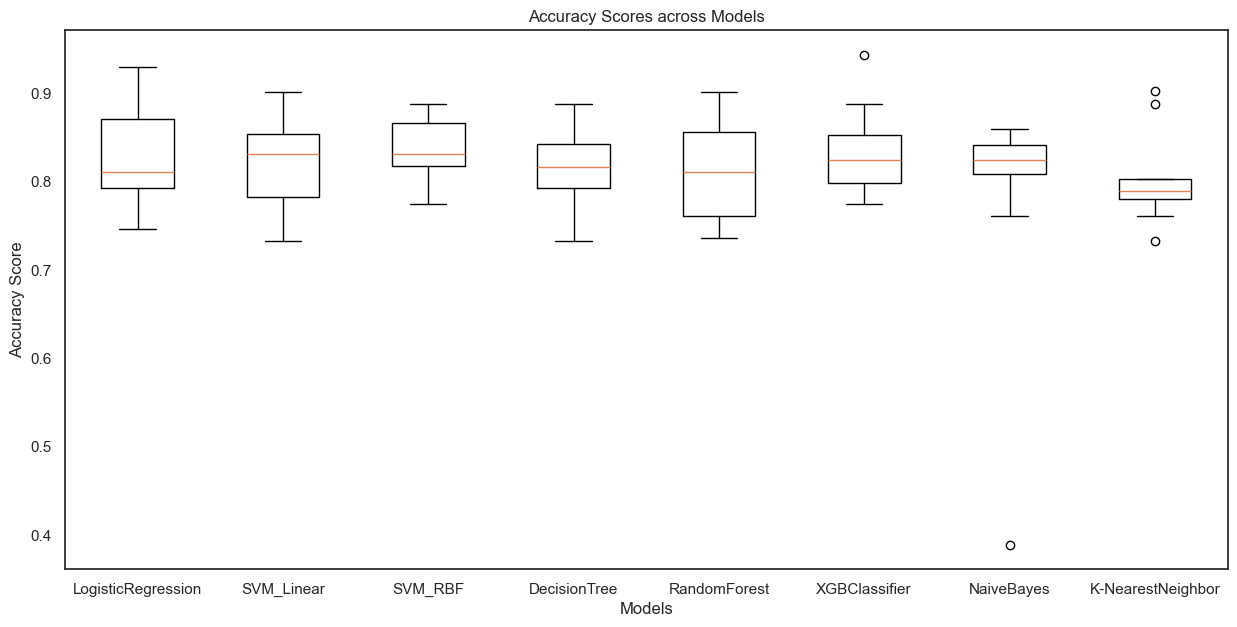

In [117]:
mod = ['LogisticRegression', 'SVM_Linear', 'SVM_RBF', 'DecisionTree', 'RandomForest', 'XGBClassifier', 'NaiveBayes', 'K-NearestNeighbor']
acc_scores = [lr_acc_results_knn, svml_acc_results_knn, svmk_acc_results_knn, tree_acc_results_knn, rf_acc_results_knn, xgb_acc_results_knn, nb_acc_results_knn, knn_acc_results_knn]
auc_scores = [lr_auc_results_knn, svml_auc_results_knn, svmk_auc_results_knn, tree_auc_results_knn, rf_auc_results_knn, xgb_auc_results_knn, nb_auc_results_knn, knn_auc_results_knn]

fig, ax = plt.subplots(figsize=(15, 7))
plt.boxplot(acc_scores)

ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Models')
ax.set_title('Accuracy Scores across Models')
ax.set_xticklabels(mod)

plt.show()

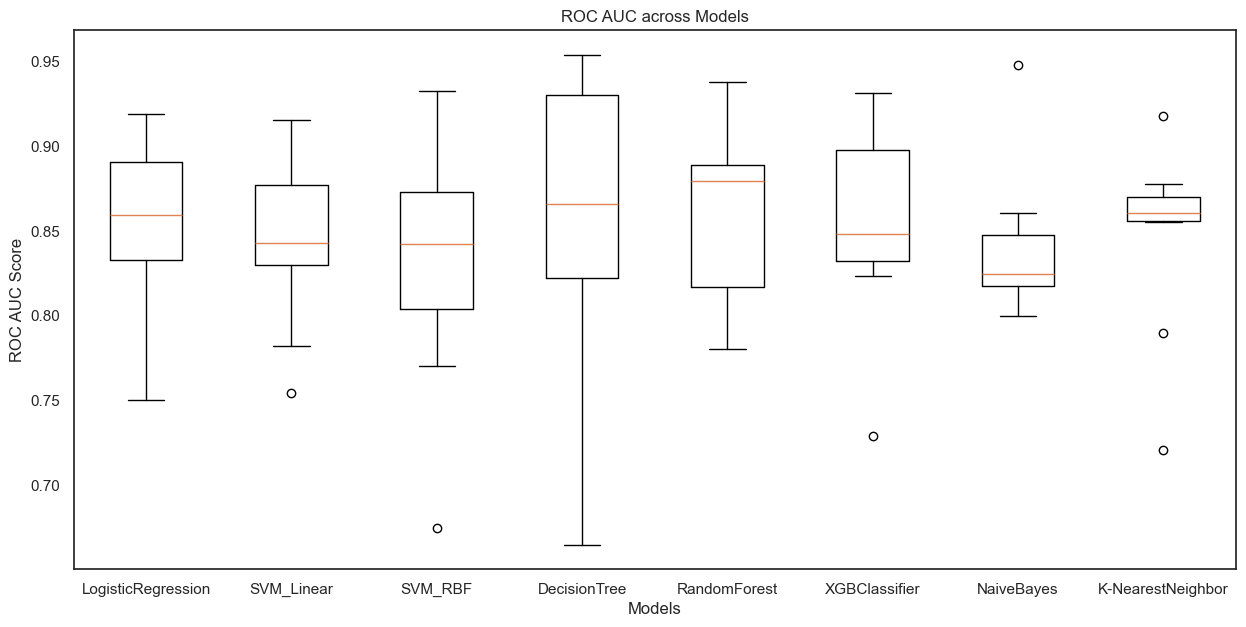

In [118]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.boxplot(auc_scores)

ax.set_ylabel('ROC AUC Score')
ax.set_xlabel('Models')
ax.set_title('ROC AUC across Models')
ax.set_xticklabels(mod)

plt.show()

__Observations:__

From accuracy score, we can see that XGBClassifier and Logistic Regression have performed better than the rest. SVM_Linear has long whiskers although it could hit higher accuracy value, making it unsuitable. When looking at ROC AUC score, we see that it is still XGBClassifier that has a better distribution of scores. However, the highest median belongs to RandomForest.

### Optimising parameters

#### Random Forest Optimisation
We assume the best number of estimators for RandomForest to be 100, but it can be less. Write a loop to check the best number of estimators.

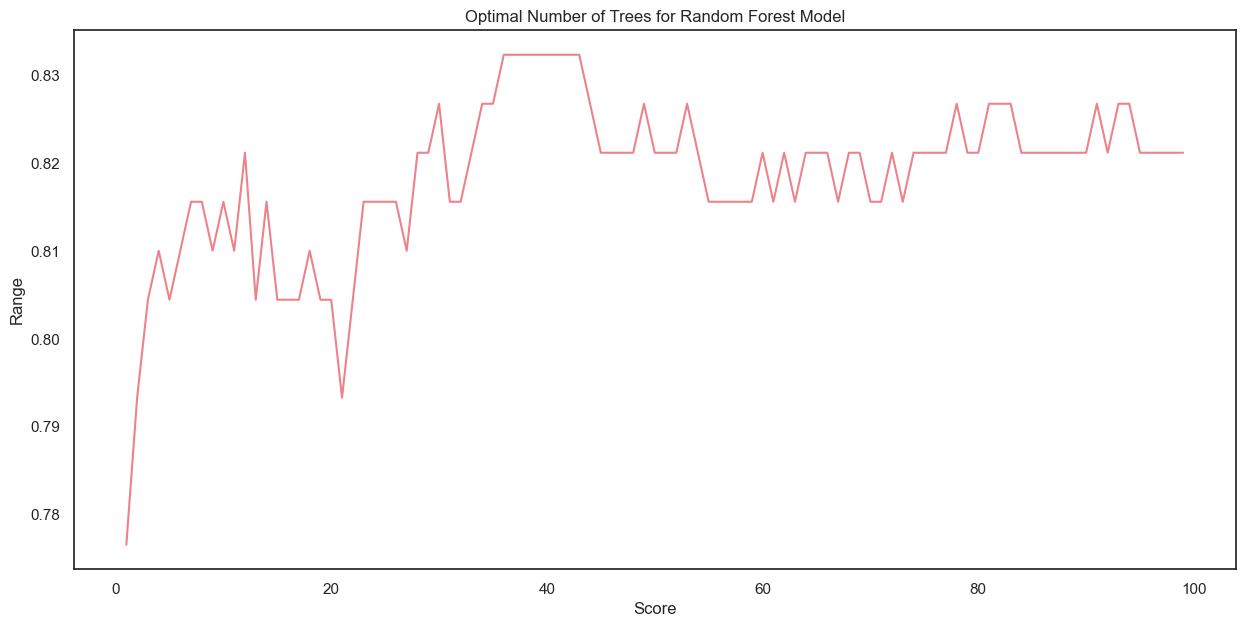

The most optimal trees is 36 with a value of 0.8324022346368715


In [140]:
score_array = []
for i in range(1, 100):
    rf_loop = RandomForestClassifier(n_estimators=i, criterion='entropy', random_state=0, n_jobs=-1)
    
    rf_loop.fit(X_train_knn, y_train)
    score_array.append(rf_loop.score(X_test_knn, y_test))
    
# Plot the accuracy results
fig = plt.figure(figsize=(15,7))
plt.plot(range(1, 100), score_array, color='#ec838a')

plt.ylabel('Range')
plt.xlabel('Score')
plt.title('Optimal Number of Trees for Random Forest Model')

plt.show()
print(f"The most optimal trees is {score_array.index(max(score_array))+1} with a value of {max(score_array)}")

#### Logistic Regression GridSearchCV

In [143]:
parameters = {
    'C': [0.0001, 0.001, 0.01, 0.02, 0.05],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression()
lr_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
t0 = time.time()
lr_cv.fit(X_train_knn, y_train)
t1 = time.time()
print("Took 0.2%f seconds"%(t1-t0))

print("tuned hyperparameters :(best parameters) ",lr_cv.best_params_)
print("accuracy :",lr_cv.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Took 0.20.065051 seconds
tuned hyperparameters :(best parameters)  {'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8070791245791245


#### XGBClassifier GridSearchCV

In [144]:
parameters = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.3]
}

xgb_clf = XGBClassifier()
xgb_cv = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=10, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
t0 = time.time()
xgb_cv.fit(X_train_knn, y_train)
t1 = time.time()
print("Took 0.2%f seconds"%(t1-t0))

print("tuned hyperparameters :(best parameters) ",xgb_cv.best_params_)
print("accuracy :",xgb_cv.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Took 0.26.447044 seconds
tuned hyperparameters :(best parameters)  {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
accuracy : 0.8109388759388759


## 2nd iteration

In [160]:
# Predicting the test results
y_pred = lr_cv.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

results = pd.DataFrame([['LogisticRegression', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  LogisticRegression  0.815642   0.759494  0.810811  0.784314       0.8


In [161]:
# Predicting the test results
svm_l = SVC(kernel='linear', random_state=0)
svm_l.fit(X_train_knn, y_train)
y_pred = svm_l.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['SVM (Linear)', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
1        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
0  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000


In [162]:
# Predicting the test results
svm_rbf = SVC(kernel='rbf', random_state=0)
svm_rbf.fit(X_train_knn, y_train)
y_pred = svm_rbf.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['SVM (RBF)', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
2           SVM (RBF)  0.810056   0.794118  0.729730  0.760563  0.741758
0        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
1  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000


In [163]:
# Predicting the test results
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
tree.fit(X_train_knn, y_train)
y_pred = tree.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['DecisionTree', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
3        DecisionTree  0.815642   0.797101  0.743243  0.769231  0.753425
0           SVM (RBF)  0.810056   0.794118  0.729730  0.760563  0.741758
1        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
2  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000


In [164]:
# Predicting the test results
randomForest = RandomForestClassifier(n_estimators=36, criterion='entropy',random_state=0)
randomForest.fit(X_train_knn, y_train)
y_pred = randomForest.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['RandomForest', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
4        RandomForest  0.832402   0.797297  0.797297  0.797297  0.797297
0        DecisionTree  0.815642   0.797101  0.743243  0.769231  0.753425
1           SVM (RBF)  0.810056   0.794118  0.729730  0.760563  0.741758
2        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
3  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000


In [165]:
# Predicting the test results
y_pred = xgb_cv.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['XGB Classifier', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0        RandomForest  0.832402   0.797297  0.797297  0.797297  0.797297
1        DecisionTree  0.815642   0.797101  0.743243  0.769231  0.753425
2           SVM (RBF)  0.810056   0.794118  0.729730  0.760563  0.741758
5      XGB Classifier  0.821229   0.791667  0.770270  0.780822  0.774457
3        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
4  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000


In [166]:
# Predicting the test results
naive_b = GaussianNB()
naive_b.fit(X_train_knn, y_train)
y_pred = naive_b.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['Naive Bayes', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0        RandomForest  0.832402   0.797297  0.797297  0.797297  0.797297
1        DecisionTree  0.815642   0.797101  0.743243  0.769231  0.753425
2           SVM (RBF)  0.810056   0.794118  0.729730  0.760563  0.741758
3      XGB Classifier  0.821229   0.791667  0.770270  0.780822  0.774457
4        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
5  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000
6         Naive Bayes  0.782123   0.710843  0.797297  0.751592  0.778364


In [167]:
# Predicting the test results
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn_model.fit(X_train_knn, y_train)
y_pred = knn_model.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['K-Nearest Neighbor', acc, prec, rec, f1, f2]], columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results = results.sort_values(['Precision', 'Recall', 'F2 Score'], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0        RandomForest  0.832402   0.797297  0.797297  0.797297  0.797297
1        DecisionTree  0.815642   0.797101  0.743243  0.769231  0.753425
2           SVM (RBF)  0.810056   0.794118  0.729730  0.760563  0.741758
3      XGB Classifier  0.821229   0.791667  0.770270  0.780822  0.774457
4        SVM (Linear)  0.815642   0.773333  0.783784  0.778523  0.781671
5  LogisticRegression  0.815642   0.759494  0.810811  0.784314  0.800000
7  K-Nearest Neighbor  0.782123   0.739726  0.729730  0.734694  0.731707
6         Naive Bayes  0.782123   0.710843  0.797297  0.751592  0.778364


__Observations:__

We can conclude that Random Forest is the optimal choice for the dataset given the combination of precision, recall and F2 score.

## Model Evaluation

In [168]:
accuracies = cross_val_score(estimator=randomForest, X=X_train_knn, y=y_train, cv=10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.80 (+/- 0.09)


Therefore, our k-fold Cross validation results indicate that we would have an accuracy between 71% to 89% while running this result.

### Visualising on the confusion matrix

In [169]:
randomForest = RandomForestClassifier(n_estimators=36, criterion='entropy',random_state=0)
randomForest.fit(X_train_knn, y_train)
y_pred = randomForest.predict(X_test_knn)

# Evaluate results
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2.0)

In [172]:
def plot_confusion_matrix(y, y_predict):
    """
    This function plots the confusion matrix by using a heat map
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.set(font_scale=1.0)
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); #annot=True to annotate the cells

    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(['Not survived', 'Survived'])
    ax.yaxis.set_ticklabels(['Not survived', 'Survived'])
    plt.show()

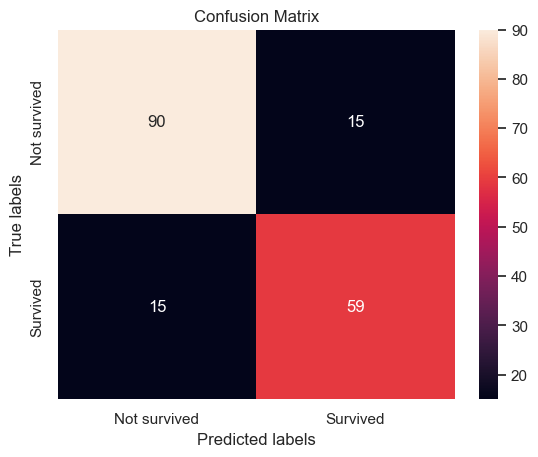

In [173]:
plot_confusion_matrix(y_test, y_pred)

### Evaluating the ROC Graph

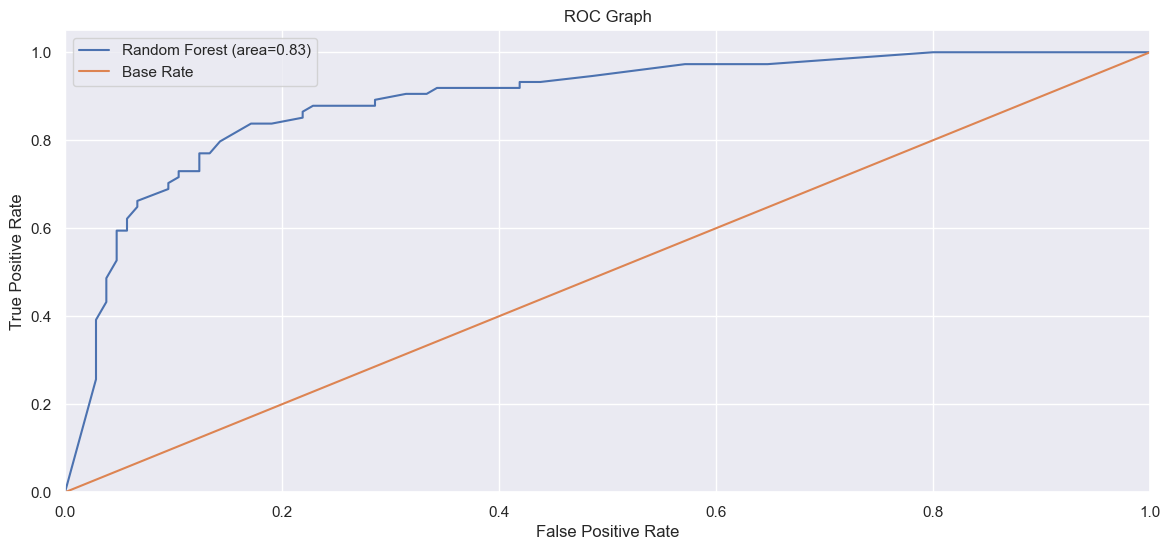

In [174]:
probs = randomForest.predict_proba(X_test_knn)
probs = probs[:, 1]
randomForest_roc_auc = accuracy_score(y_test, y_pred)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, randomForest.predict_proba(X_test_knn)[:,1])
plt.figure(figsize=(14, 6))

# Plot RandomForest ROC AUC curve
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area=%0.2f)'%randomForest_roc_auc)

# Plot base rate ROC
plt.plot([0,1], [0,1], label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.title('ROC Graph')

plt.legend(loc='upper left')
plt.show()

## Model Improvement

### Hyperparameter tuning via GridSearch

In [196]:
parameters = { 
    'n_estimators': range(30, 101), 
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9, None],
} 

randomForest = RandomForestClassifier(criterion='entropy', random_state=0)
rf_cv = GridSearchCV(estimator=randomForest, param_grid=parameters, cv=10, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
t0 = time.time()
rf_cv.fit(X_train_knn, y_train)
t1 = time.time()
print("Took 0.2%f seconds"%(t1-t0))

print("tuned hyperparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

Fitting 10 folds for each of 2556 candidates, totalling 25560 fits
Took 0.2265.738031 seconds
tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 64}
accuracy : 0.813973063973064


In [197]:
# Predicting the Test set results
y_hat = rf_cv.predict(X_test_knn)

# Probability score
y_hat_probs = rf_cv.predict_proba(X_test_knn)
y_hat_probs = y_hat_probs[:,1]

### Re-evaluate with Confusion Matrix

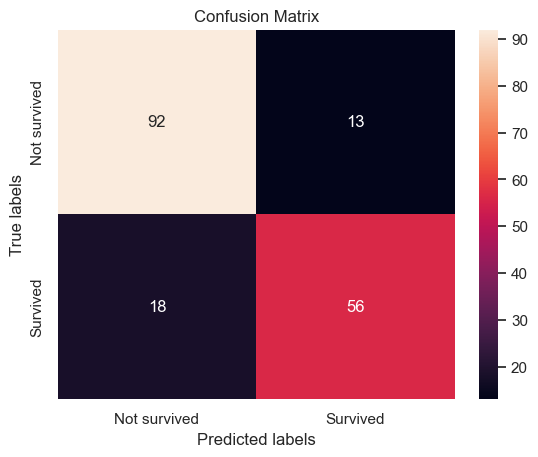

In [198]:
plot_confusion_matrix(y_test, y_hat)

## Saving the results

In [219]:
features = test_dataset_clean.drop(columns=['PassengerId'])

In [220]:
# Conduct Feature Scaling
# sc = StandardScaler()

# X_train2 = pd.DataFrame(sc.fit_transform(X_train))
# X_train2.columns = X_train.columns
# X_train2.index = X_train.index.values
# X_train = X_train2

features_scale = pd.DataFrame(sc.transform(features))
features_scale.columns = features.columns
features_scale.index = features.index.values
features = features_scale

In [221]:
features = features.drop(columns=['GroupImpute_Age', 'MICE_Age'])

In [224]:
y_predictions = rf_cv.predict(features)

y_predictions[0:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [228]:
result_df = pd.DataFrame([identity_test, y_predictions]).T

result_df.rename(columns={'Unnamed 0': 'Survived'}, inplace=True)

result_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [229]:
# write to file
file_name = 'gender_submission.csv'
result_df.to_csv(file_name, index=False)